# Taller ASP - Daniel Crovo - Deep Learning
**Objetivos**
- Predecir los valores futuros de una serie temporal haciendo uso de técnicas de Deep Learning.
- Implementar la optimización de hiperparámetros y cuantificar el efecto a través de métricas de desempeño.

En el ámbito de la ingenierı́a eléctrica, uno de los principales desafı́os es la planificación y gestión eficiente de la producción de energı́a eléctrica. La potencia activa es una medida de la energı́a eléctrica que se consume o se produce en un sistema eléctrico en un momento dado, y su estimación precisa es esencial para garantizar que la producción de energı́a eléctrica se ajuste a la demanda en tiempo real. Además, la potencia activa es uno de los factores clave que determinan la estabilidad y la calidad de la energı́a eléctrica suministrada a los consumidores. Por lo anterior, la predicción de la potencia activa global que se espera que se consuma o produzca en las próximas 24 horas es un problema crı́tico en la planificación y gestión de la producción de energı́a eléctrica. Una solución precisa y confiable para este problema puede ayudar a mejorar la eficiencia y la estabilidad de la red eléctrica, ası́ como a reducir los costos y las emisiones de gases de efecto invernadero asociados con la producción de energı́a eléctrica.

1. Omitiendo la primera y última fase de la metodologı́a CRISP-DM (Data Understanding, Data Preparation, Modeling y Evaluation), desarrolle un modelo de DL que, dado el consumo de energı́a de las 24 horas del dı́a anterior, tenga la capacidad de predecir el consumo de las 24 horas del dı́a siguiente. Describa la cadena de procesamiento y justifique, en detalle, cada fase que consolidó la metodologı́a empleada.
    
- **Data Understanding:** Inicialmente se explorarlos para obtener información sobre la distribución de los datos, la presencia de valores faltantes y cualquier otra característica que pueda afectar el modelado. El dataset consiste en datos de cosumo de energía (Potencia activa) y tiene tres columnas: Fecha, hora y potencia activa. El dataset tiene valores nulos.  

- **Preprocesar los datos:** Una vez que se han explorado los datos, es necesario preprocesarlos para prepararlos para el modelado, a continuación se listan los procesos realizados.
    - Se realiza el ajuste del dataframe a uno de dos columnas, en la cual se configura el index como el *time step*, esta columna es el resulatado de concatenar la fecha y hora y hacerle un cast para que sea un tipo de dato datetime. Adicionalmente a la columna index, se deja la potencia activa como la única columna.
    - Posteriormente se realiza una separación del dataset en train y test, se deja el último año (2010) como conjunto de pruebas.
    - Dado que el dataset contiene valores nulos, se remplazan estos por el valor de la media en cada conjunto de datos (entrenamiento y validación)
    - Se realiza un *re-sampling* para disminuir el tamaño del dataset, considerando que el objetivo del modelo es predecir las 24 horas del día siguiente dado un día anterior, además reduce el tiempo de entrenamiento. 

- **Crear el modelo:** En este paso, se crea un modelo de DL que pueda predecir el consumo de energía de las 24 horas del día siguiente, dados los datos de consumo de las 24 horas del día anterior. Un enfoque común para este problema es usar una red neuronal recurrente (RNN), como una red LSTM o GRU. En este caso se consideró sólamente implementar un LSTM, para lo cual se siguo la siguiente metodología:
    - Se creó una clase dataset para gestionar el conjunto de datos. en esta clase se realiza una escalización con el módulo MinMaxScaler() para escalizar los valores de potencia a un número entre 0 y 1 con el fin de reducir el tiempo de convergencia.
    - se creó un modelo base (BaseLineModel) basado en el módulo nn.LSTM que permite crear n celdas LSTM apiladas automáticamente (A diferencia de nn.LSTMCell)
    - Se creó un modelo más (CONV-LSTM-MODEL)sofisiticado utilizando dos capas convolucionales 1d para realizar extracción de características. seguido de un nn.LSTM y se agregan funciones de activación ReLU. 

- **Entrenar el modelo:** Después de crear el modelo, es necesario entrenarlo utilizando los datos de entrenamiento preprocesados.
    - Se entrenaron 2 modelos *BaseLineModel* con el fin de comparar el rendimiento utilizando una secuencia de 1440(sin *re-sampling*) o 24 (con *re-sampling*)
    - Se entrena el modelo *CONV-LSTM-MODEL*
    - Todos fueron entrenados por 5 épocas.
    - La función de pérdida escogida fue MSELOSS
    - Se escogieron 2 métricas de evaluación MSE y SMAPE (Ver referencias).

- **Evaluar el modelo:** Una vez que se ha entrenado el modelo, es necesario evaluarlo utilizando los datos de prueba preprocesados. 
    - Se evalauaron los 3 modelos, una vez entrenados se guarda el *state_dict* y se procede a realizar una evaluación con los datos de prueba. Se encontró que el modelo *CONV-LSTM-MODEL* es el que mejor rendimiento tiene. por lo cual se selecciona para realizar una optimización de hiperparametros

- **Ajustar el modelo:** Si el modelo no proporciona un rendimiento adecuado en los datos de prueba, se deben realizar ajustes en la arquitectura del modelo o en los hiperparámetros. 
    - Se plantea una optimización de hiperparámetros inicialmente por medio de gridsearch utilizando la librería optuna. El espacio de búsqueda seleccionado es el siguiente: 
    ```
    
        params = {
                    'kernel_size': [2, 4, 6],
                    'feature_size': [32, 64, 128, 256],
                    'hidden_size': [32, 64, 128, 256],
                    'n_layers': [2,4,8],
                    'lr': [0.001, 0.01],
                    'optimizer': ["Adam", 'RMSprop']}
   
    ```
    
    - Después de esta optimización por grid search, se realizará una optimización de hiperparámetros bayesiana con la librería optuna.

## Preprocesamiento de los datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import os 
import numpy as np
from sklearn.metrics import mean_squared_error
import multiprocessing
from sklearn.metrics import r2_score


data = pd.read_csv('../data/data_asp.csv')
data.head()

,Fecha,Hora,Potencia Activa Global (W)
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


In [2]:
# Renombrar columnas y concatenar Fecha y Hora para utilizarlas como index
data.rename(columns={'Potencia Activa Global (W)':'Power'}, inplace=True) 
data['Power'] = pd.to_numeric(data['Power'], errors='coerce')
data['Datetime'] = data['Fecha'] +" "+ data['Hora']     
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True)

# Se eliminan las columnas pues ya no se requieren
data.drop(['Fecha', 'Hora'], axis=1,inplace=True)
data.set_index('Datetime', inplace=True)
data.head()

,Power
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [3]:
train = data.loc['2006-12-16 17:24:00':'2010-01-01 00:00:00'].copy()
test = data.loc['2010-01-01 00:01:00':].copy()

In [4]:
train.shape

(1600237, 1)

In [5]:
test.shape

(475022, 1)

In [6]:
# Se verifica información básica del dataset
data.describe()

,Power
count,2.049280e+06
mean,1.091615e+00
std,1.057294e+00
min,7.600000e-02
25%,3.080000e-01
50%,6.020000e-01
75%,1.528000e+00
max,1.112200e+01


In [7]:
# Las siguientes lineas de código se utilizarn para verificar cómo están distribuidos los datos núlos

# grouped = data.groupby(by=data.index.month)
# nan = data[pd.isna(data['Power'])]
# nan = nan.fillna(1)
# nan_values = nan.groupby(by=[nan.index.month,nan.index.day,nan.index.year]).count()

data[pd.isna(data['Power'])].size

25979

Existen 25979 datos nulos, los cuales se van a reemplazar por el valor de la media.

In [8]:
#data.fillna(data['Power'].mean(), inplace=True)
train.fillna(train['Power'].mean(), inplace=True)
test.fillna(test['Power'].mean(), inplace=True)

In [9]:
# Se verifica que no queden valores nulos
data[pd.isna(data['Power'])].size

25979

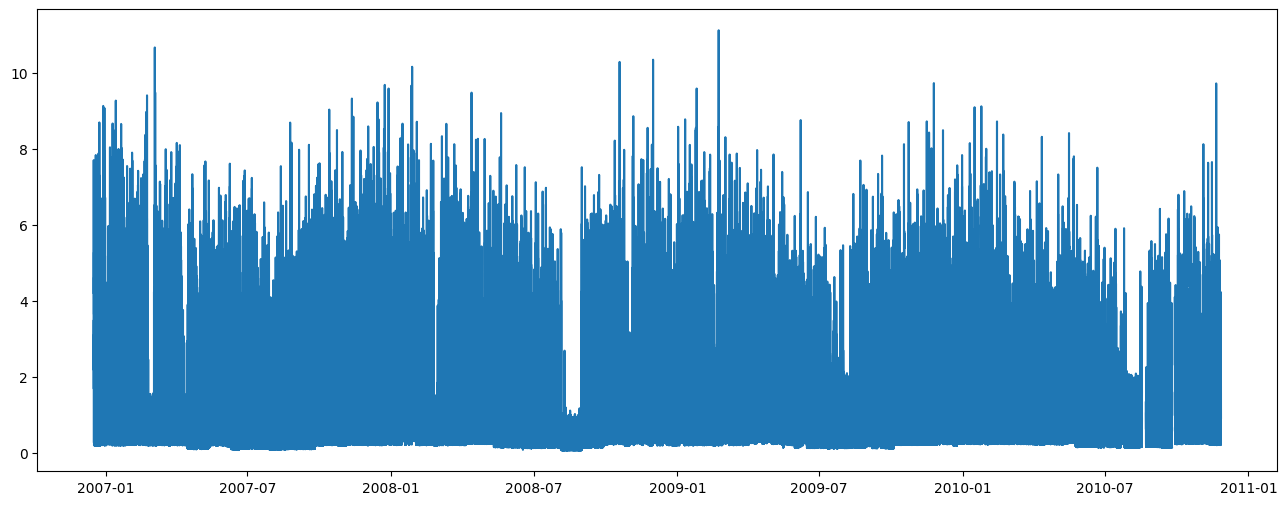

In [10]:
plt.figure(figsize=(16,6))
plt.plot(data)

Considerando que el problema consiste en predecir las siguientes 24 horas de consumo, dadas las 24 horas previas, hace sentido hacer un re-muestreo del dataset. 

In [11]:
#data_hour = data.resample('H').mean()
train_hour = train.resample('H').mean()
test_hour = test.resample('H').mean()


<Axes: xlabel='Datetime'>

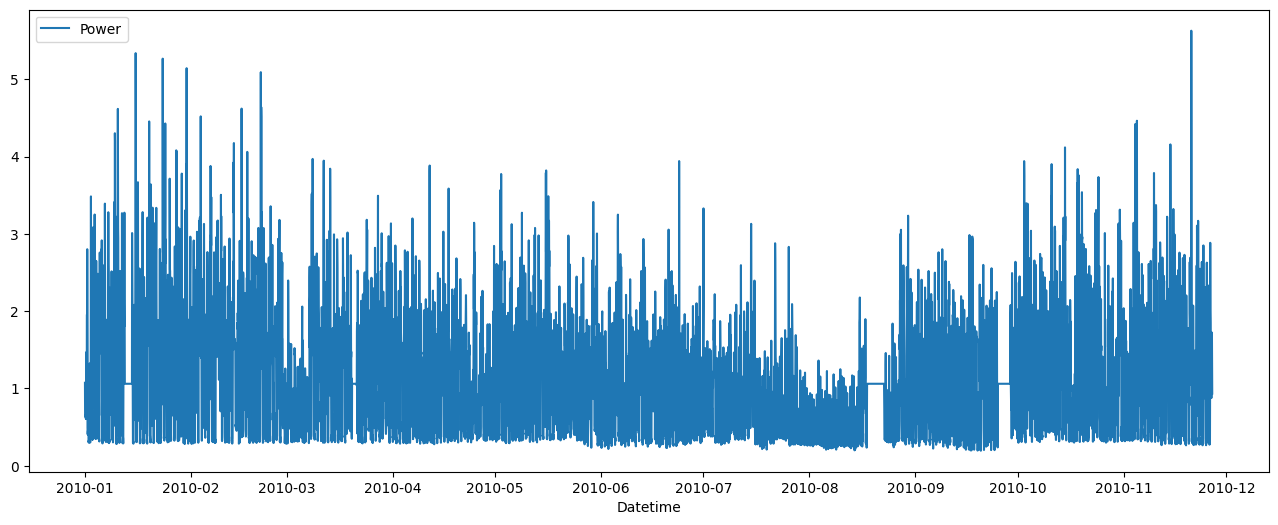

In [12]:
plt.figure(figsize=(16,6))
sns.lineplot(test_hour)

## Creación del modelo

In [13]:
# Clase para manejar el dataset
class PowerData(Dataset): 
    def __init__(self, data_df, seq_length):
        self.data = data_df
        self.seq_length = seq_length
        self.scaler = MinMaxScaler()
        self.scaler.fit(self.data[['Power']].values)

    def __getitem__(self, index):
        
        # Se retorna la secuencia del día inicial
        input_seq = torch.tensor(self.scaler.transform(self.data.iloc[index:index+self.seq_length]['Power'].values.reshape(-1,1)))
        # Se retorna la secuencia del día siguiente
        target = torch.tensor(self.scaler.transform(self.data.iloc[index+self.seq_length:index+(self.seq_length*2)]['Power'].values.reshape(-1,1)))
        return input_seq, target 
    def __len__(self): 
        return(len(self.data) - self.seq_length*2)
    # Función para retornar los datos en su escala original
    def inverse_transform(self, data): 
        return(self.scaler.inverse_transform(data))
            

In [14]:
#Modelo Base
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, seq_lenght, n_layers):
        super(BaselineModel, self).__init__()
        #Modulo LSTM de n_layer celdas
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, seq_lenght)
    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        # se debe aplicar la capa lineal a la última secuencia 
        x = self.linear(x[:,-1,:]).unsqueeze(-1)

        return x

In [15]:
# Función de entrenamiento
def train_model(model, device, train_loader, optimizer, criterion, epoch):
    p_bar = tqdm(train_loader)
    model.train()

    for batch_idx, (data, target) in enumerate(p_bar):

        data, target = data.to(device), target.to(device)
        with torch.cuda.amp.autocast():
            output = model(data)
            loss = criterion(output, target)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        p_bar.set_postfix(loss= loss.item())

In [16]:
#Función de evaluación del modelo
def performance(model, device, val_loader, test_data):
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            prev_day, next_day= x.to(device), y.to(device)
            pred = model(prev_day)

            preds = np.concatenate(pred.cpu().detach().numpy())
            targets = np.concatenate(next_day.cpu().detach().numpy())

    
 
    smape = (100/len(targets))*np.sum((np.abs(preds-targets))/((np.abs(targets+preds))/2))
    preds = test_data.inverse_transform(preds.reshape(-1,1))
    targets = test_data.inverse_transform(targets.reshape(-1,1))
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print('Mean Squared Error: ', mse)
    return preds, targets, smape, mse, r2

### Entrenamiento y evaluación del modelo base 24
Para este caso se entrena por 5 epocas y se entrena con los datos *re-muestreados* y se obtienen los siguientes resultados: 
```
____________________________
Validation metrics in training epoch  10 :
Mean Squared Error:  0.8327834626289765
Simetric absolute percentage error: 54.0897583601329
Mean Squared error: 0.8327834626289765
R2 Score: 0.3165344200991952
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2596639287578807
Simetric absolute percentage error: 65.781269962956
Mean Squared error: 0.2596639287578807
R2 Score: 0.5062643651777057
```

In [17]:
# Hyperparámetros
batch_size = 32
epochs = 10
lr  = 0.001
input_size =1
seq_lenght = 24
hidden_size = 64
n_layers = 2
#NUM_WORKERS =  multiprocessing.cpu_count() No funciona en windows

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

#train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=NUM_WORKERS)
#test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=NUM_WORKERS)
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

model = BaselineModel(input_size, hidden_size, seq_lenght, n_layers).to(device)
model.double()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, epochs+1):
    train_model(model, device, train_loader, optimizer, criterion, epoch)
    print('____________________________\nValidation metrics in training epoch ', epoch,':')
    preds, targets, smape, mse, r2 = performance(model, device, train_loader, train_data)
    print(f'Simetric absolute percentage error: {smape}')
    print(f'Mean Squared error: {mse}')
    print(f'R2 Score: {r2}')


print('____________________________\nValidation metrics in test set:')
preds, targets, smape, mse, r2 = performance(model, device, test_loader, test_data)
print(f'Simetric absolute percentage error: {smape}')
print(f'Mean Squared error: {mse}')
print(f'R2 Score: {r2}')

torch.save(model.state_dict(), '../models/model_24hours')


Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  1.2081553604296251
Simetric absolute percentage error: 72.07898017376645
Mean Squared error: 1.2081553604296251
R2 Score: 0.008466616976780972


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  1.134746375820449
Simetric absolute percentage error: 68.83780169102361
Mean Squared error: 1.134746375820449
R2 Score: 0.06871338758081358


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.9135278858974818
Simetric absolute percentage error: 57.474816175977395
Mean Squared error: 0.9135278858974818
R2 Score: 0.25026745329518274


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.8794759071381689
Simetric absolute percentage error: 56.08597685003378
Mean Squared error: 0.8794759071381689
R2 Score: 0.27821392011866286


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  5 :
Mean Squared Error:  0.8241473609208722
Simetric absolute percentage error: 53.50439029353887
Mean Squared error: 0.8241473609208722
R2 Score: 0.323622070763365


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  6 :
Mean Squared Error:  0.790325513062813
Simetric absolute percentage error: 52.45574349018157
Mean Squared error: 0.790325513062813
R2 Score: 0.3513796691030956


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  7 :
Mean Squared Error:  0.7946995041073986
Simetric absolute percentage error: 52.357403902841114
Mean Squared error: 0.7946995041073986
R2 Score: 0.34778993364373467


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  8 :
Mean Squared Error:  0.808711105408965
Simetric absolute percentage error: 52.712883175691445
Mean Squared error: 0.808711105408965
R2 Score: 0.3362906092230954


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  9 :
Mean Squared Error:  0.8230766565606068
Simetric absolute percentage error: 53.49334914711611
Mean Squared error: 0.8230766565606068
R2 Score: 0.3245007980788438


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  10 :
Mean Squared Error:  0.8327834626289765
Simetric absolute percentage error: 54.0897583601329
Mean Squared error: 0.8327834626289765
R2 Score: 0.3165344200991952
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2596639287578807
Simetric absolute percentage error: 65.781269962956
Mean Squared error: 0.2596639287578807
R2 Score: 0.5062643651777057


### Entrenamiento y evaluación del modelo base por minutos
Para este caso se entrena por 2 epocas y se entrena con los datos sin ser *re-muestreados*
>Este modelo se descartó desde el inicio pues tarda mucho en entrenar y no tiene un rendimiendo mejor que el modelo anterior. 

In [ ]:
batch_size = 32
epochs = 2
lr  = 0.001
input_size =1
seq_lenght = 1440
hidden_size = 64
n_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data_h = PowerData(train, seq_lenght)
test_data_h = PowerData(test, seq_lenght)

train_loader_h = DataLoader(train_data_h, batch_size=batch_size, num_workers=NUM_WORKERS)
test_loader_h = DataLoader(test_data_h, batch_size=batch_size, num_workers=NUM_WORKERS)

model_hour = BaselineModel(input_size, hidden_size, seq_lenght, n_layers).to(device)
model_hour.double()
optimizer_h = optim.Adam(model_hour.parameters(), lr=lr)
criterion_h = nn.MSELoss()

for epoch in range(1, epochs+1):
    train_model(model_hour, device, train_loader_h, optimizer_h, criterion_h, epoch)
    print('____________________________\nValidation metrics in training epoch ', epoch,':')
    performance(model_hour, device, train_loader_h, train_data_h)


print('____________________________\nValidation metrics in test set:')
performance(model_hour, device, test_loader_h, test_data)

torch.save(model_hour.state_dict(), '../models/model_by_hours')



## Evaluación de los dos modelos base

In [ ]:
model_baseline24 = BaselineModel(1, hidden_size, 24, 2).to(device)
model_baseline24.load_state_dict(torch.load('../models/model_24hours'))
model_baseline24.eval()
model_baseline24.double()
model_baseline_h = BaselineModel(1440, hidden_size, 1440, 1).to(device)
model_baseline_h.load_state_dict(torch.load('../models/model_by_hours'))
model_baseline_h.eval()
model_baseline_h.double()


#train_data_24 = PowerData(train_hour, input_size)
test_data_24 = PowerData(test_hour, 24)
test_data_h = PowerData(test, 1440)

#train_loader_24 = DataLoader(train_data_24, batch_size=batch_size)
test_loader_24 = DataLoader(test_data_24, batch_size=batch_size)
test_loader_h = DataLoader(test_data_h, batch_size=batch_size)

y_pred_24, y_true_24, mse  = performance(model_baseline24, device, test_loader_24,test_data_24)
y_pred_h, y_true_h, mse = performance(model_baseline_h, device, test_loader_h,test_data_h)


print(f'el RMSE para el modelo que trabaja con una secuencia de 24 y fue remuestreado es: {mean_squared_error(y_true_24, y_pred_24)}')
print(f'el RMSE para el modelo que trabaja con una secuencia de 1440: {mean_squared_error(y_true_h, y_pred_h)}')

## Modelo con extracción de características por Convolución
Este modelo se basa en la siguiente arquitectura de la referencia: 5. [Multi-Step Short-Term Power Consumption Forecasting with a Hybrid Deep Learning Strategy](https://www.mdpi.com/1996-1073/11/11/3089)

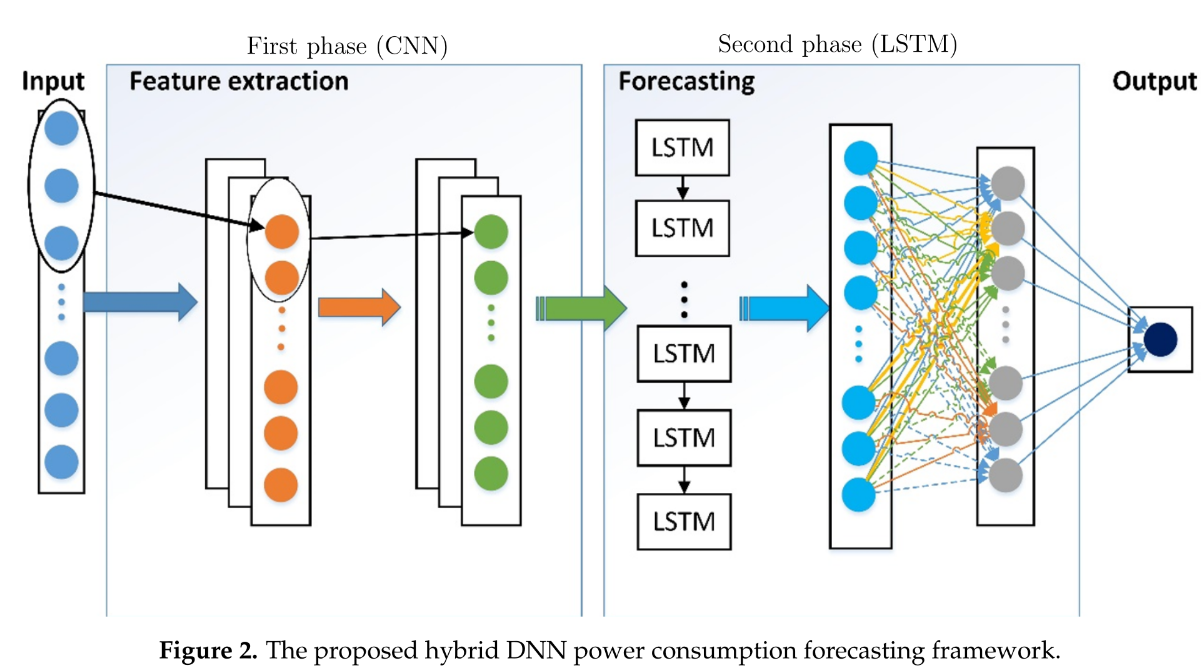



### Resultados del modelo sin optimización de parámetros
```
____________________________
Validation metrics in training epoch  80 :
Simetric absolute percentage error: 43.166815567221214
Mean Squared error: 0.3577338438254845
R2 Score: 0.7064077518440609
____________________________
Validation metrics in test set:
Simetric absolute percentage error: 61.157898794403955
Mean Squared error: 0.27506694344548843
R2 Score: 0.47697644185565546

```

In [18]:
class CONV_LSTM_Model(nn.Module):
    def __init__(self, input_size=1, kernel_size=3, feature_size=32, hidden_size=64, seq_lenght=24, n_layers=2, padding=1, drop_prob=0.3):
        super(CONV_LSTM_Model, self).__init__()
        # Dos capas convolucionales
        self.conv1d_1 = nn.Conv1d(in_channels=input_size, out_channels=feature_size, kernel_size=kernel_size, padding=padding)
        self.conv1d_2 = nn.Conv1d(in_channels=feature_size, out_channels=feature_size, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size*feature_size, hidden_size, n_layers, batch_first=True, dropout=drop_prob)
        self.linear = nn.Linear(hidden_size, seq_lenght)
    def forward(self, x):
        # esta operación es necesaria por las dimenciones de entrada que admite el módulo conv1d
        # El Dataset retorna un tensor con tamaño [32, 24, 1] ([batch_size, seq_length, features_size])
        # La entrada debe ser [32, 1, 24] ([batch_size, in_chanels, seq_lenght])
        x = x.permute(0,2,1)
        x = self.conv1d_1(x)
        x = self.relu(x)
        x = self.conv1d_2(x)
        x = self.relu(x)
        # Se permuta para volver a las dimensiones de entrada rqueridas por el lstm
        x = x.permute(0,2,1)
        x, h = self.lstm(x)
        x = self.linear(x[:,-1,:]).unsqueeze(-1)
        x = self.relu(x)

        return x

In [19]:
# Hyperparámetros
batch_size = 32
epochs = 10
lr  = 0.001
input_size =1
seq_lenght = 24
kernel_size = 3
feature_size = 64
padding = 1
hidden_size = 64
n_layers = 2
#NUM_WORKERS = multiprocessing.cpu_count()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

conv_lstm_model = CONV_LSTM_Model(input_size, kernel_size, feature_size, hidden_size, seq_lenght, n_layers, padding).to(device)
conv_lstm_model.double()
optimizer = optim.Adam(conv_lstm_model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, epochs+1):
    train_model(conv_lstm_model, device, train_loader, optimizer, criterion, epoch)
    print('____________________________\nValidation metrics in training epoch ', epoch,':')
    preds, targets, smape, mse, r2 = performance(conv_lstm_model, device, train_loader, train_data)
    print(f'Simetric absolute percentage error: {smape}')
    print(f'Mean Squared error: {mse}')
    print(f'R2 Score: {r2}')


print('____________________________\nValidation metrics in test set:')
preds, targets, smape, mse, r2  = performance(conv_lstm_model, device, test_loader, test_data)
print(f'Simetric absolute percentage error: {smape}')
print(f'Mean Squared error: {mse}')
print(f'R2 Score: {r2}')
torch.save(conv_lstm_model.state_dict(), '../models/conv_lstm_model')



Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  1.3755198889564397
Simetric absolute percentage error: 83.1408779105314
Mean Squared error: 1.3755198889564397
R2 Score: -0.12888949019578244


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.8435308687729738
Simetric absolute percentage error: 54.86173433257564
Mean Squared error: 0.8435308687729738
R2 Score: 0.3077140213974151


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.8077297612654739
Simetric absolute percentage error: 52.07716502889245
Mean Squared error: 0.8077297612654739
R2 Score: 0.3370959985880523


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.7877476254142547
Simetric absolute percentage error: 50.61039821453652
Mean Squared error: 0.7877476254142547
R2 Score: 0.3534953420909801


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  5 :
Mean Squared Error:  0.7671367362931557
Simetric absolute percentage error: 50.72391743835366
Mean Squared error: 0.7671367362931557
R2 Score: 0.3704107035475501


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  6 :
Mean Squared Error:  0.7680051613532107
Simetric absolute percentage error: 51.678667851371614
Mean Squared error: 0.7680051613532107
R2 Score: 0.36969798690041933


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  7 :
Mean Squared Error:  0.7711489647270454
Simetric absolute percentage error: 52.27598705659175
Mean Squared error: 0.7711489647270454
R2 Score: 0.36711786674624514


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  8 :
Mean Squared Error:  0.7730572294487477
Simetric absolute percentage error: 52.52651091253554
Mean Squared error: 0.7730572294487477
R2 Score: 0.3655517534489118


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  9 :
Mean Squared Error:  0.7691321465338093
Simetric absolute percentage error: 52.41833016122238
Mean Squared error: 0.7691321465338093
R2 Score: 0.3687730699027092


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  10 :
Mean Squared Error:  0.7745699665149907
Simetric absolute percentage error: 52.864053190771294
Mean Squared error: 0.7745699665149907
R2 Score: 0.3643102497896613
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24747598730067355
Simetric absolute percentage error: 65.22419292246644
Mean Squared error: 0.24747598730067355
R2 Score: 0.5294390165100521


In [31]:
# Hyperparámetros
batch_size = 32
epochs = 80
lr  = 0.001
input_size =1
seq_lenght = 24
kernel_size = 3
feature_size = 64
padding = 1
hidden_size = 64
n_layers = 2
#NUM_WORKERS = multiprocessing.cpu_count()
del train_data, test_data, train_loader, test_loader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

conv_lstm_model = CONV_LSTM_Model(input_size, kernel_size, feature_size, hidden_size, seq_lenght, n_layers, padding).to(device)
conv_lstm_model.double()
optimizer = optim.Adam(conv_lstm_model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, epochs+1):
    train_model(conv_lstm_model, device, train_loader, optimizer, criterion, epoch)
    print('____________________________\nValidation metrics in training epoch ', epoch,':')
    preds, targets, smape, mse, r2 = performance(conv_lstm_model, device, train_loader, train_data)
    print(f'Simetric absolute percentage error: {smape}')
    print(f'Mean Squared error: {mse}')
    print(f'R2 Score: {r2}')
    print('____________________________\nValidation metrics in test set:')
    preds_v, targets_v, smape_v, mse_v, r2_v  = performance(conv_lstm_model, device, test_loader, test_data)
    print(f'Simetric absolute percentage error: {smape_v}')
    print(f'Mean Squared error: {mse_v}')
    print(f'R2 Score: {r2_v}')


print('____________________________\nValidation metrics in test set:')
preds, targets, smape, mse, r2  = performance(conv_lstm_model, device, test_loader, test_data)
print(f'Simetric absolute percentage error: {smape}')
print(f'Mean Squared error: {mse}')
print(f'R2 Score: {r2}')
torch.save(conv_lstm_model.state_dict(), '../models/conv_lstm_model')


Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  1.7005870394043556
Simetric absolute percentage error: 103.9613564079836
Mean Squared error: 1.7005870394043556
R2 Score: -0.39567217556062073
____________________________
Validation metrics in test set:
Mean Squared Error:  0.648100422249524
Simetric absolute percentage error: 112.08564213060691
Mean Squared error: 0.648100422249524
R2 Score: -0.23232470115760795


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  1.3711269417994079
Simetric absolute percentage error: 86.65759417854635
Mean Squared error: 1.3711269417994079
R2 Score: -0.12528419745056363
____________________________
Validation metrics in test set:
Mean Squared Error:  0.501947953043571
Simetric absolute percentage error: 97.07843755284378
Mean Squared error: 0.501947953043571
R2 Score: 0.04557559292417823


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.9401204510783314
Simetric absolute percentage error: 61.876253793185256
Mean Squared error: 0.9401204510783314
R2 Score: 0.2284429289164166
____________________________
Validation metrics in test set:
Mean Squared Error:  0.32781195599628965
Simetric absolute percentage error: 74.51792609114472
Mean Squared error: 0.32781195599628965
R2 Score: 0.3766849135711773


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.9314599344749014
Simetric absolute percentage error: 59.993245510573786
Mean Squared error: 0.9314599344749014
R2 Score: 0.23555061689081258
____________________________
Validation metrics in test set:
Mean Squared Error:  0.32375526125474297
Simetric absolute percentage error: 73.24372612434716
Mean Squared error: 0.32375526125474297
R2 Score: 0.38439847919070325


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  5 :
Mean Squared Error:  0.9213100627032783
Simetric absolute percentage error: 59.17018121390702
Mean Squared error: 0.9213100627032783
R2 Score: 0.24388061899533542
____________________________
Validation metrics in test set:
Mean Squared Error:  0.3215386994820238
Simetric absolute percentage error: 72.25154862306817
Mean Squared error: 0.3215386994820238
R2 Score: 0.3886131405771015


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  6 :
Mean Squared Error:  0.9017895557762038
Simetric absolute percentage error: 58.233721554351554
Mean Squared error: 0.9017895557762038
R2 Score: 0.259901103533721
____________________________
Validation metrics in test set:
Mean Squared Error:  0.3167887183450913
Simetric absolute percentage error: 71.23711312090677
Mean Squared error: 0.3167887183450913
R2 Score: 0.3976449493587674


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  7 :
Mean Squared Error:  0.9160426959544882
Simetric absolute percentage error: 58.915535212258845
Mean Squared error: 0.9160426959544882
R2 Score: 0.2482035481012368
____________________________
Validation metrics in test set:
Mean Squared Error:  0.31700714603946184
Simetric absolute percentage error: 71.65504905404192
Mean Squared error: 0.31700714603946184
R2 Score: 0.39722962198981515


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  8 :
Mean Squared Error:  0.9063034692916627
Simetric absolute percentage error: 58.25596567881997
Mean Squared error: 0.9063034692916627
R2 Score: 0.2561965336702344
____________________________
Validation metrics in test set:
Mean Squared Error:  0.3151637948353266
Simetric absolute percentage error: 71.10775212834594
Mean Squared error: 0.3151637948353266
R2 Score: 0.40073464550743587


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  9 :
Mean Squared Error:  0.9135604255404327
Simetric absolute percentage error: 58.72696735817064
Mean Squared error: 0.9135604255404327
R2 Score: 0.250240748002706
____________________________
Validation metrics in test set:
Mean Squared Error:  0.31424532801023014
Simetric absolute percentage error: 71.22104707008182
Mean Squared error: 0.31424532801023014
R2 Score: 0.40248105596622186


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  10 :
Mean Squared Error:  0.928316504562419
Simetric absolute percentage error: 59.33369739339522
Mean Squared error: 0.928316504562419
R2 Score: 0.23813043054516891
____________________________
Validation metrics in test set:
Mean Squared Error:  0.3107560907465662
Simetric absolute percentage error: 71.07967178093752
Mean Squared error: 0.3107560907465662
R2 Score: 0.40911563468364975


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  11 :
Mean Squared Error:  0.7989271933649441
Simetric absolute percentage error: 52.31663239868395
Mean Squared error: 0.7989271933649441
R2 Score: 0.344320268094749
____________________________
Validation metrics in test set:
Mean Squared Error:  0.25287808229314684
Simetric absolute percentage error: 64.51688186426836
Mean Squared error: 0.25287808229314684
R2 Score: 0.5191672517207034


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  12 :
Mean Squared Error:  0.7716950779531985
Simetric absolute percentage error: 51.46661174958669
Mean Squared error: 0.7716950779531985
R2 Score: 0.3666696714955542
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24714803207598587
Simetric absolute percentage error: 63.6952338895766
Mean Squared error: 0.24714803207598587
R2 Score: 0.5300626040134417


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  13 :
Mean Squared Error:  0.768554986270519
Simetric absolute percentage error: 51.77645931672932
Mean Squared error: 0.768554986270519
R2 Score: 0.3692467454639411
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24654632494734097
Simetric absolute percentage error: 63.64373813922408
Mean Squared error: 0.24654632494734097
R2 Score: 0.5312067146050041


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  14 :
Mean Squared Error:  0.7684614988946725
Simetric absolute percentage error: 51.91466465283418
Mean Squared error: 0.7684614988946725
R2 Score: 0.3693234705748656
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24128077460289682
Simetric absolute percentage error: 63.10477871797228
Mean Squared error: 0.24128077460289682
R2 Score: 0.5412188478051723


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  15 :
Mean Squared Error:  0.7646528299797737
Simetric absolute percentage error: 52.12823460639134
Mean Squared error: 0.7646528299797737
R2 Score: 0.37244924603197416
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24076674547192453
Simetric absolute percentage error: 62.83777956815664
Mean Squared error: 0.24076674547192453
R2 Score: 0.5421962438590324


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  16 :
Mean Squared Error:  0.7519756039735427
Simetric absolute percentage error: 52.119566794827364
Mean Squared error: 0.7519756039735427
R2 Score: 0.38285344833989443
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2368902239584629
Simetric absolute percentage error: 62.3935065975524
Mean Squared error: 0.2368902239584629
R2 Score: 0.5495672207194183


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  17 :
Mean Squared Error:  0.7451899014253126
Simetric absolute percentage error: 52.171158137918496
Mean Squared error: 0.7451899014253126
R2 Score: 0.38842247598667257
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23403462629742774
Simetric absolute percentage error: 62.250686127257815
Mean Squared error: 0.23403462629742774
R2 Score: 0.5549969711307006


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  18 :
Mean Squared Error:  0.742846143602394
Simetric absolute percentage error: 52.789055887012445
Mean Squared error: 0.742846143602394
R2 Score: 0.3903459985726414
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2275778358349865
Simetric absolute percentage error: 61.78785546845513
Mean Squared error: 0.2275778358349865
R2 Score: 0.5672741771066623


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  19 :
Mean Squared Error:  0.733918561284093
Simetric absolute percentage error: 52.214854303175585
Mean Squared error: 0.733918561284093
R2 Score: 0.3976728674408434
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2218753283937129
Simetric absolute percentage error: 61.44602422905575
Mean Squared error: 0.2218753283937129
R2 Score: 0.578117158436662


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  20 :
Mean Squared Error:  0.7266022596416555
Simetric absolute percentage error: 51.76504586757848
Mean Squared error: 0.7266022596416555
R2 Score: 0.4036773578866456
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21958867823262362
Simetric absolute percentage error: 61.18549453210745
Mean Squared error: 0.21958867823262362
R2 Score: 0.5824650887568361


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  21 :
Mean Squared Error:  0.7281887876442473
Simetric absolute percentage error: 51.81137083816941
Mean Squared error: 0.7281887876442473
R2 Score: 0.40237529398891025
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21600582336002358
Simetric absolute percentage error: 60.881680105359095
Mean Squared error: 0.21600582336002358
R2 Score: 0.58927767583222


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  22 :
Mean Squared Error:  0.7238779887668847
Simetric absolute percentage error: 52.00763861102719
Mean Squared error: 0.7238779887668847
R2 Score: 0.405913167622053
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2181671679887873
Simetric absolute percentage error: 61.33155029092886
Mean Squared error: 0.2181671679887873
R2 Score: 0.5851680065860636


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  23 :
Mean Squared Error:  0.7291401955008636
Simetric absolute percentage error: 52.18186652294934
Mean Squared error: 0.7291401955008636
R2 Score: 0.40159447334149767
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21020527926246493
Simetric absolute percentage error: 60.49831494781214
Mean Squared error: 0.21020527926246493
R2 Score: 0.6003070680778917


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  24 :
Mean Squared Error:  0.7311979607103786
Simetric absolute percentage error: 52.19950982908081
Mean Squared error: 0.7311979607103786
R2 Score: 0.3999056649593271
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21125450369049936
Simetric absolute percentage error: 60.81716642014039
Mean Squared error: 0.21125450369049936
R2 Score: 0.5983120297546071


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  25 :
Mean Squared Error:  0.7211779362418703
Simetric absolute percentage error: 52.27664699843312
Mean Squared error: 0.7211779362418703
R2 Score: 0.408129101352228
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20368237105668002
Simetric absolute percentage error: 60.070292277819355
Mean Squared error: 0.20368237105668002
R2 Score: 0.6127099930404643


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  26 :
Mean Squared Error:  0.7264520725273469
Simetric absolute percentage error: 52.441861875358335
Mean Squared error: 0.7264520725273469
R2 Score: 0.4038006164860065
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20019441123434867
Simetric absolute percentage error: 59.37947735784693
Mean Squared error: 0.20019441123434867
R2 Score: 0.6193421427785945


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  27 :
Mean Squared Error:  0.6972382723620992
Simetric absolute percentage error: 51.87693424755086
Mean Squared error: 0.6972382723620992
R2 Score: 0.42777638902118087
____________________________
Validation metrics in test set:
Mean Squared Error:  0.19275503084501724
Simetric absolute percentage error: 58.91087797590869
Mean Squared error: 0.19275503084501724
R2 Score: 0.633487685506772


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  28 :
Mean Squared Error:  0.7291383171318891
Simetric absolute percentage error: 53.25439317591817
Mean Squared error: 0.7291383171318891
R2 Score: 0.40159601491934827
____________________________
Validation metrics in test set:
Mean Squared Error:  0.19611041605999935
Simetric absolute percentage error: 59.435904672477754
Mean Squared error: 0.19611041605999935
R2 Score: 0.6271076185597866


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  29 :
Mean Squared Error:  0.7191653256077485
Simetric absolute percentage error: 53.816108895272386
Mean Squared error: 0.7191653256077485
R2 Score: 0.4097808513639565
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18984856437374142
Simetric absolute percentage error: 58.96484021365668
Mean Squared error: 0.18984856437374142
R2 Score: 0.639014159958382


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  30 :
Mean Squared Error:  0.6885417629142938
Simetric absolute percentage error: 53.38421639192723
Mean Squared error: 0.6885417629142938
R2 Score: 0.43491361633125925
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18769868194565917
Simetric absolute percentage error: 58.41539539293158
Mean Squared error: 0.18769868194565917
R2 Score: 0.6431020345064569


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  31 :
Mean Squared Error:  0.6911163759038099
Simetric absolute percentage error: 53.74845028685345
Mean Squared error: 0.6911163759038099
R2 Score: 0.4328006308568062
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1898624702028958
Simetric absolute percentage error: 59.01553051399116
Mean Squared error: 0.1898624702028958
R2 Score: 0.6389877188449855


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  32 :
Mean Squared Error:  0.6752983266126605
Simetric absolute percentage error: 53.67012323577275
Mean Squared error: 0.6752983266126605
R2 Score: 0.44578250755923954
____________________________
Validation metrics in test set:
Mean Squared Error:  0.19453875932955608
Simetric absolute percentage error: 59.6027436693381
Mean Squared error: 0.19453875932955608
R2 Score: 0.6300960310714516


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  33 :
Mean Squared Error:  0.6431644991025848
Simetric absolute percentage error: 53.380677844448975
Mean Squared error: 0.6431644991025848
R2 Score: 0.47215474720995776
____________________________
Validation metrics in test set:
Mean Squared Error:  0.19392939249553798
Simetric absolute percentage error: 59.64404043764053
Mean Squared error: 0.19392939249553798
R2 Score: 0.6312547061406951


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  34 :
Mean Squared Error:  0.6388205961636276
Simetric absolute percentage error: 54.051486704418636
Mean Squared error: 0.6388205961636276
R2 Score: 0.4757197893540883
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1845513680025958
Simetric absolute percentage error: 58.73754281301748
Mean Squared error: 0.1845513680025958
R2 Score: 0.6490864662105323


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  35 :
Mean Squared Error:  0.6284819619676263
Simetric absolute percentage error: 53.805249955446676
Mean Squared error: 0.6284819619676263
R2 Score: 0.48420470882384536
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1889415065929517
Simetric absolute percentage error: 58.74174900945631
Mean Squared error: 0.1889415065929517
R2 Score: 0.6407388767927957


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  36 :
Mean Squared Error:  0.6118831813806019
Simetric absolute percentage error: 53.18031257554042
Mean Squared error: 0.6118831813806019
R2 Score: 0.4978273318809163
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18692620092650408
Simetric absolute percentage error: 59.21972101094103
Mean Squared error: 0.18692620092650408
R2 Score: 0.644570861571522


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  37 :
Mean Squared Error:  0.6345662153910155
Simetric absolute percentage error: 53.120008462663236
Mean Squared error: 0.6345662153910155
R2 Score: 0.47921136063564673
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18741948496240357
Simetric absolute percentage error: 59.24929182867592
Mean Squared error: 0.18741948496240357
R2 Score: 0.6436329110915398


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  38 :
Mean Squared Error:  0.6168626855176848
Simetric absolute percentage error: 52.38719992665854
Mean Squared error: 0.6168626855176848
R2 Score: 0.4937406516868523
____________________________
Validation metrics in test set:
Mean Squared Error:  0.19003897343900328
Simetric absolute percentage error: 59.97070871416774
Mean Squared error: 0.19003897343900328
R2 Score: 0.6386521083589831


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  39 :
Mean Squared Error:  0.6010133185105474
Simetric absolute percentage error: 51.74448969972524
Mean Squared error: 0.6010133185105474
R2 Score: 0.506748230846022
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18300090724230172
Simetric absolute percentage error: 59.11125755724555
Mean Squared error: 0.18300090724230172
R2 Score: 0.652034575835973


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  40 :
Mean Squared Error:  0.5987464040210421
Simetric absolute percentage error: 50.602971531216106
Mean Squared error: 0.5987464040210421
R2 Score: 0.508608688090531
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1824158963602315
Simetric absolute percentage error: 58.79115116210566
Mean Squared error: 0.1824158963602315
R2 Score: 0.6531469395001084


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  41 :
Mean Squared Error:  0.59101533466067
Simetric absolute percentage error: 50.88439071751815
Mean Squared error: 0.59101533466067
R2 Score: 0.514953578498128
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1807249277492626
Simetric absolute percentage error: 59.23066046044389
Mean Squared error: 0.1807249277492626
R2 Score: 0.6563622165106469


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  42 :
Mean Squared Error:  0.5789489849284574
Simetric absolute percentage error: 50.53975878510986
Mean Squared error: 0.5789489849284574
R2 Score: 0.5248564345070337
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1775594545035276
Simetric absolute percentage error: 58.68453280678955
Mean Squared error: 0.1775594545035276
R2 Score: 0.6623811770569661


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  43 :
Mean Squared Error:  0.6219582415027942
Simetric absolute percentage error: 51.835714575072124
Mean Squared error: 0.6219582415027942
R2 Score: 0.48955872771434017
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18171323154418728
Simetric absolute percentage error: 59.16926729324657
Mean Squared error: 0.18171323154418728
R2 Score: 0.6544830151756034


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  44 :
Mean Squared Error:  0.6049499437562655
Simetric absolute percentage error: 51.47739607230254
Mean Squared error: 0.6049499437562655
R2 Score: 0.5035174415986909
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1792357836527037
Simetric absolute percentage error: 59.21005323806285
Mean Squared error: 0.1792357836527037
R2 Score: 0.6591937361189861


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  45 :
Mean Squared Error:  0.5981127613941825
Simetric absolute percentage error: 50.346867771286064
Mean Squared error: 0.5981127613941825
R2 Score: 0.5091287187405744
____________________________
Validation metrics in test set:
Mean Squared Error:  0.17514630448027607
Simetric absolute percentage error: 58.97291922222653
Mean Squared error: 0.17514630448027607
R2 Score: 0.6669696393988515


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  46 :
Mean Squared Error:  0.5837214605603185
Simetric absolute percentage error: 51.77551896634835
Mean Squared error: 0.5837214605603185
R2 Score: 0.5209396626549663
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18169998640423254
Simetric absolute percentage error: 59.124472186110324
Mean Squared error: 0.18169998640423254
R2 Score: 0.6545082000274816


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  47 :
Mean Squared Error:  0.5521218672564117
Simetric absolute percentage error: 50.57211377620349
Mean Squared error: 0.5521218672564117
R2 Score: 0.5468734561694351
____________________________
Validation metrics in test set:
Mean Squared Error:  0.17736464982380395
Simetric absolute percentage error: 58.68268108765083
Mean Squared error: 0.17736464982380395
R2 Score: 0.6627515866578291


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  48 :
Mean Squared Error:  0.5453357555074283
Simetric absolute percentage error: 50.55628902071176
Mean Squared error: 0.5453357555074283
R2 Score: 0.5524428196473659
____________________________
Validation metrics in test set:
Mean Squared Error:  0.17650920074041118
Simetric absolute percentage error: 58.94347371101154
Mean Squared error: 0.17650920074041118
R2 Score: 0.6643781726001565


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  49 :
Mean Squared Error:  0.534158362429253
Simetric absolute percentage error: 49.5657214595887
Mean Squared error: 0.534158362429253
R2 Score: 0.5616161087252229
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18650836603285148
Simetric absolute percentage error: 59.48856149767713
Mean Squared error: 0.18650836603285148
R2 Score: 0.6453653499606307


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  50 :
Mean Squared Error:  0.5032264903493644
Simetric absolute percentage error: 49.445485938984476
Mean Squared error: 0.5032264903493644
R2 Score: 0.5870019032770983
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1865920549930085
Simetric absolute percentage error: 58.397895107082626
Mean Squared error: 0.1865920549930085
R2 Score: 0.6452062203423259


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  51 :
Mean Squared Error:  0.5074716207131452
Simetric absolute percentage error: 48.45128201422375
Mean Squared error: 0.5074716207131452
R2 Score: 0.5835179238082017
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1776212328188121
Simetric absolute percentage error: 57.795612214994144
Mean Squared error: 0.1776212328188121
R2 Score: 0.6622637092366911


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  52 :
Mean Squared Error:  0.5303577079757072
Simetric absolute percentage error: 50.39611854385507
Mean Squared error: 0.5303577079757072
R2 Score: 0.56473530671205
____________________________
Validation metrics in test set:
Mean Squared Error:  0.17911112205377325
Simetric absolute percentage error: 57.94087133665223
Mean Squared error: 0.17911112205377325
R2 Score: 0.6594307727916588


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  53 :
Mean Squared Error:  0.5419689243446967
Simetric absolute percentage error: 50.33258535586744
Mean Squared error: 0.5419689243446967
R2 Score: 0.5552059787593399
____________________________
Validation metrics in test set:
Mean Squared Error:  0.19833657359617587
Simetric absolute percentage error: 57.964708306129
Mean Squared error: 0.19833657359617587
R2 Score: 0.6228747113955289


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  54 :
Mean Squared Error:  0.4970783783743707
Simetric absolute percentage error: 48.12671912963147
Mean Squared error: 0.4970783783743707
R2 Score: 0.5920476601933307
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1918443091136302
Simetric absolute percentage error: 57.69525195156844
Mean Squared error: 0.1918443091136302
R2 Score: 0.6352193691269953


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  55 :
Mean Squared Error:  0.4818017310281691
Simetric absolute percentage error: 47.59556199908747
Mean Squared error: 0.4818017310281691
R2 Score: 0.6045852081946452
____________________________
Validation metrics in test set:
Mean Squared Error:  0.18023063385216118
Simetric absolute percentage error: 57.4321932509039
Mean Squared error: 0.18023063385216118
R2 Score: 0.6573020871821011


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  56 :
Mean Squared Error:  0.4893624254534938
Simetric absolute percentage error: 47.23119305557255
Mean Squared error: 0.4893624254534938
R2 Score: 0.5983801445355468
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1910599280578169
Simetric absolute percentage error: 57.57626467799769
Mean Squared error: 0.1910599280578169
R2 Score: 0.63671082340941


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  57 :
Mean Squared Error:  0.48276425624472613
Simetric absolute percentage error: 46.62929451373936
Mean Squared error: 0.48276425624472613
R2 Score: 0.6037952635273646
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1890781200180804
Simetric absolute percentage error: 57.00624501859357
Mean Squared error: 0.1890781200180804
R2 Score: 0.6404791144280197


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  58 :
Mean Squared Error:  0.4606478280034049
Simetric absolute percentage error: 46.13090802889603
Mean Squared error: 0.4606478280034049
R2 Score: 0.6219462212872253
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2006834914010433
Simetric absolute percentage error: 57.774932866687614
Mean Squared error: 0.2006834914010433
R2 Score: 0.6184121857077871


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  59 :
Mean Squared Error:  0.4439877077629267
Simetric absolute percentage error: 45.24306581826925
Mean Squared error: 0.4439877077629267
R2 Score: 0.6356191858120368
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2102443854509602
Simetric absolute percentage error: 58.980033468528596
Mean Squared error: 0.2102443854509602
R2 Score: 0.6002327099685674


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  60 :
Mean Squared Error:  0.4513652476771588
Simetric absolute percentage error: 46.23596401428179
Mean Squared error: 0.4513652476771588
R2 Score: 0.6295644371024451
____________________________
Validation metrics in test set:
Mean Squared Error:  0.1961459736390877
Simetric absolute percentage error: 58.270797857386285
Mean Squared error: 0.1961459736390877
R2 Score: 0.6270400079218058


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  61 :
Mean Squared Error:  0.45878006077147754
Simetric absolute percentage error: 45.294441210688
Mean Squared error: 0.45878006077147754
R2 Score: 0.6234790982853577
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20171990105258658
Simetric absolute percentage error: 58.455016707609424
Mean Squared error: 0.20171990105258658
R2 Score: 0.6164415139256552


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  62 :
Mean Squared Error:  0.452866049326986
Simetric absolute percentage error: 47.04695493791134
Mean Squared error: 0.452866049326986
R2 Score: 0.6283327288422006
____________________________
Validation metrics in test set:
Mean Squared Error:  0.19457911303112915
Simetric absolute percentage error: 57.636386348529356
Mean Squared error: 0.19457911303112915
R2 Score: 0.6300193008896396


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  63 :
Mean Squared Error:  0.42090221656146437
Simetric absolute percentage error: 45.13849257978574
Mean Squared error: 0.42090221656146437
R2 Score: 0.6545654537668459
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2130882867947092
Simetric absolute percentage error: 58.313281466693674
Mean Squared error: 0.2130882867947092
R2 Score: 0.5948251994142726


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  64 :
Mean Squared Error:  0.4460433426995892
Simetric absolute percentage error: 46.03581636949728
Mean Squared error: 0.4460433426995892
R2 Score: 0.6339321257452877
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20356974241432202
Simetric absolute percentage error: 58.01083425305049
Mean Squared error: 0.20356974241432202
R2 Score: 0.6129241497564155


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  65 :
Mean Squared Error:  0.4167939313950963
Simetric absolute percentage error: 45.30130421656469
Mean Squared error: 0.4167939313950963
R2 Score: 0.657937124350656
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20627159808939252
Simetric absolute percentage error: 58.01118785649192
Mean Squared error: 0.20627159808939252
R2 Score: 0.6077867306573884


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  66 :
Mean Squared Error:  0.4047600566697165
Simetric absolute percentage error: 44.228502864482266
Mean Squared error: 0.4047600566697165
R2 Score: 0.667813328113962
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20340290031168984
Simetric absolute percentage error: 58.602209046947976
Mean Squared error: 0.20340290031168984
R2 Score: 0.6132413901673276


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  67 :
Mean Squared Error:  0.4080101195891877
Simetric absolute percentage error: 45.05156450600304
Mean Squared error: 0.4080101195891877
R2 Score: 0.66514600072617
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20707787750518208
Simetric absolute percentage error: 59.08634240383153
Mean Squared error: 0.20707787750518208
R2 Score: 0.6062536379359493


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  68 :
Mean Squared Error:  0.4074105065120129
Simetric absolute percentage error: 46.57632888767792
Mean Squared error: 0.4074105065120129
R2 Score: 0.6656381033169367
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23160834979982578
Simetric absolute percentage error: 60.046664520372595
Mean Squared error: 0.23160834979982578
R2 Score: 0.5596103926888212


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  69 :
Mean Squared Error:  0.37833667954154393
Simetric absolute percentage error: 43.74848251771815
Mean Squared error: 0.37833667954154393
R2 Score: 0.6894989998188648
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22494783475842942
Simetric absolute percentage error: 59.25736939595159
Mean Squared error: 0.22494783475842942
R2 Score: 0.5722749689275703


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  70 :
Mean Squared Error:  0.3716809358308386
Simetric absolute percentage error: 46.504867098908086
Mean Squared error: 0.3716809358308386
R2 Score: 0.6949613702177052
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22755422995073993
Simetric absolute percentage error: 58.519046042267185
Mean Squared error: 0.22755422995073993
R2 Score: 0.5673190623023066


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  71 :
Mean Squared Error:  0.358365709977539
Simetric absolute percentage error: 43.245799570609755
Mean Squared error: 0.358365709977539
R2 Score: 0.7058891791472997
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22589881857399433
Simetric absolute percentage error: 59.316943453605234
Mean Squared error: 0.22589881857399433
R2 Score: 0.5704667293306046


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  72 :
Mean Squared Error:  0.3647539816695519
Simetric absolute percentage error: 43.84016365179797
Mean Squared error: 0.3647539816695519
R2 Score: 0.7006463230959054
____________________________
Validation metrics in test set:
Mean Squared Error:  0.25219574717815724
Simetric absolute percentage error: 59.85766322626721
Mean Squared error: 0.25219574717815724
R2 Score: 0.5204646716695291


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  73 :
Mean Squared Error:  0.3719049770231373
Simetric absolute percentage error: 45.03765598298119
Mean Squared error: 0.3719049770231373
R2 Score: 0.6947774995594999
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2393905503488776
Simetric absolute percentage error: 60.03096779973453
Mean Squared error: 0.2393905503488776
R2 Score: 0.5448129976606375


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  74 :
Mean Squared Error:  0.37987267080870196
Simetric absolute percentage error: 43.517054142469284
Mean Squared error: 0.37987267080870196
R2 Score: 0.6882384114315585
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21004435283452721
Simetric absolute percentage error: 58.455189240584374
Mean Squared error: 0.21004435283452721
R2 Score: 0.6006130601825233


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  75 :
Mean Squared Error:  0.357408180088344
Simetric absolute percentage error: 42.80963972130228
Mean Squared error: 0.357408180088344
R2 Score: 0.706675024148262
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2540186282026864
Simetric absolute percentage error: 61.449754311849965
Mean Squared error: 0.2540186282026864
R2 Score: 0.5169985709902523


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  76 :
Mean Squared Error:  0.3815110638754738
Simetric absolute percentage error: 42.45699226284375
Mean Squared error: 0.3815110638754738
R2 Score: 0.6868937818636854
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23785967319860787
Simetric absolute percentage error: 59.28431107440303
Mean Squared error: 0.23785967319860787
R2 Score: 0.5477238702074676


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  77 :
Mean Squared Error:  0.3370968159077454
Simetric absolute percentage error: 42.22486231124815
Mean Squared error: 0.3370968159077454
R2 Score: 0.7233445654170636
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2396819767338965
Simetric absolute percentage error: 59.17595853616277
Mean Squared error: 0.2396819767338965
R2 Score: 0.5442588675898974


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  78 :
Mean Squared Error:  0.3462569338106576
Simetric absolute percentage error: 42.09196279341594
Mean Squared error: 0.3462569338106576
R2 Score: 0.7158268545409258
____________________________
Validation metrics in test set:
Mean Squared Error:  0.27501224574142985
Simetric absolute percentage error: 60.531921468711765
Mean Squared error: 0.27501224574142985
R2 Score: 0.4770804463115915


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  79 :
Mean Squared Error:  0.3639878638766572
Simetric absolute percentage error: 43.582781799477374
Mean Squared error: 0.3639878638766572
R2 Score: 0.7012750761452756
____________________________
Validation metrics in test set:
Mean Squared Error:  0.27846751221592403
Simetric absolute percentage error: 62.09920359819025
Mean Squared error: 0.27846751221592403
R2 Score: 0.4705104610447688


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  80 :
Mean Squared Error:  0.3577338438254845
Simetric absolute percentage error: 43.166815567221214
Mean Squared error: 0.3577338438254845
R2 Score: 0.7064077518440609
____________________________
Validation metrics in test set:
Mean Squared Error:  0.27506694344548843
Simetric absolute percentage error: 61.157898794403955
Mean Squared error: 0.27506694344548843
R2 Score: 0.47697644185565546
____________________________
Validation metrics in test set:
Mean Squared Error:  0.27506694344548843
Simetric absolute percentage error: 61.157898794403955
Mean Squared error: 0.27506694344548843
R2 Score: 0.47697644185565546


## Optimización de hiperparámetros
Considerando que el modelo con las capas convolucionales para extracción de características presenta un mejor desempeño en el entrenamiento así como evaluado en el conjunto de pruebas, se procede a realizar la optimización de hiperparámetros para este. 

In [ ]:
import optuna
del train_loader
del test_loader, train_data, test_data

batch_size = 32
epochs = 10
input_size =1
seq_lenght = 24
padding = 1
#NUM_WORKERS = multiprocessing.cpu_count()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')
train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
#train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=NUM_WORKERS)
#test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=NUM_WORKERS)

# Se define una función objetivo a minimar 
def objective(trial):

    #variables para el espacio de búsqueda
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    kernel_size = trial.suggest_int('kernel_size', 2,8)
    feature_size = trial.suggest_int('feature_size', 32, 256)
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    n_layers = trial.suggest_int('n_layers', 1, 64)

    model_HO = CONV_LSTM_Model(input_size, kernel_size, feature_size, hidden_size, seq_lenght, n_layers, padding, drop_prob=0.05).to(device)
    optimizer = getattr(optim, optimizer_name)(model_HO.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model_HO.double()
    for epoch in range(epochs):
        train_model(model_HO, device, train_loader, optimizer, criterion, epoch)
        preds, targets, mse_epoch = performance(model_HO, device, test_loader, test_data)
        trial.report(mse_epoch, epoch)
        print('____________________________\nValidation metrics in training epoch ', epoch,':')
        preds, targets, smape, mse, r2 = performance(model_HO, device, train_loader, train_data)
        print(f'Simetric absolute percentage error: {smape}')
        print(f'Mean Squared error: {mse}')
        print(f'R2 Score: {r2}')
        print('____________________________\nValidation metrics in training epoch ', epoch,':')

        preds_v, targets_v, smape_v, mse_v, r2_v  = performance(model_HO, device, test_loader, test_data)
        print(f'Simetric absolute percentage error: {smape_v}')
        print(f'Mean Squared error: {mse_v}')
        print(f'R2 Score: {r2_v}')
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    preds_final, targets_final, mse = performance(model_HO, device, test_loader, test_data)
    return mse
# Se define el espacio de busqueda
params = {
    'kernel_size': [2, 4, 6],
    'feature_size': [32, 64, 128, 256],
    'hidden_size': [32, 64, 128, 256],
    'n_layers': [2,4,8],
    'lr': [0.001, 0.0005],
    'optimizer': ["Adam", 'RMSprop']

}
# se inicia la optimización
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.GridSampler(params))
study.optimize(objective, n_trials=576, timeout=3600)


# Get the best hyperparameters and their corresponding score
best_params = study.best_params
best_score = study.best_value

# Print the best hyperparameters and score
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

El segundo mejor
```
{'optimizer': 'Adam',
 'lr': 0.001, 
 'kernel_size': 4, 
 'feature_size': 128, 
 'hidden_size': 64, 
 'n_layers': 2}
 ```

El mejor

``` 
{'optimizer': 'Adam',
 'lr': 0.001,
 'kernel_size': 6,
 'feature_size': 128,
 'hidden_size': 256,
 'n_layers': 4}
 ```

In [27]:
import optuna
del train_loader
del test_loader, train_data, test_data

batch_size = 32
epochs = 5 # por temas de tiempos se deja en 3
input_size =1
seq_lenght = 24
padding = 1
#feature_size = 128
#NUM_WORKERS = multiprocessing.cpu_count()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')
train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


def objective(trial):

    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    kernel_size = trial.suggest_int('kernel_size', 4,8)
    feature_size = trial.suggest_int('feature_size', 64, 256)
    hidden_size = trial.suggest_int('hidden_size', 64, 256)
    n_layers = trial.suggest_int('n_layers', 2, 10)

    model_HO = CONV_LSTM_Model(input_size, kernel_size, feature_size, hidden_size, seq_lenght, n_layers, padding).to(device)
    optimizer = optim.Adam(model_HO.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model_HO.double()
    for epoch in range(epochs):
        train_model(model_HO, device, train_loader, optimizer, criterion, epoch)
        preds, targets, smape, mse_epoch, r2 = performance(model_HO, device, train_loader, train_data)
        trial.report(mse_epoch, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        print('____________________________\nValidation metrics in training epoch ', epoch,':')
        print(f'Simetric absolute percentage error: {smape}')
        print(f'Mean Squared error: {mse_epoch}')
        print(f'R2 Score: {r2}')
        print('____________________________\nValidation metrics in training epoch ', epoch,':')

        preds_v, targets_v, smape_v, mse_v, r2_v  = performance(model_HO, device, test_loader, test_data)
        print(f'Simetric absolute percentage error: {smape_v}')
        print(f'Mean Squared error: {mse_v}')
        print(f'R2 Score: {r2_v}')
    
    _, _, smape, mse, r2 = performance(model_HO, device, test_loader, test_data)
    return mse

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, timeout=5000)


# Get the best hyperparameters and their corresponding score
best_params = study.best_params
best_score = study.best_value

# Print the best hyperparameters and score
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

[I 2023-05-19 14:05:34,240] A new study created in memory with name: no-name-1ca68135-45a3-4c59-8aee-6ceb51f7922d


Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.7051273464133256
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 98.55520733032942
Mean Squared error: 1.7051273464133256
R2 Score: -0.3993984065703209
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.6663035327291624
Simetric absolute percentage error: 106.41354118056339
Mean Squared error: 0.6663035327291624
R2 Score: -0.2669368413628226


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.3550676083309465
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 82.09190746129052
Mean Squared error: 1.3550676083309465
R2 Score: -0.11210429876814665
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.47700694313667197
Simetric absolute percentage error: 90.54791750143367
Mean Squared error: 0.47700694313667197
R2 Score: 0.09299945121053332


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.1906849444139216
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 73.84146912987931
Mean Squared error: 1.1906849444139216
R2 Score: 0.02280459143125313
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.43752273966234656
Simetric absolute percentage error: 86.59142084056563
Mean Squared error: 0.43752273966234656
R2 Score: 0.16807633370670116


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.0201125304739342
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 64.46637656879356
Mean Squared error: 1.0201125304739342
R2 Score: 0.16279341090245913
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.38878487387004773
Simetric absolute percentage error: 78.88794647549958
Mean Squared error: 0.38878487387004773
R2 Score: 0.26074850893702417


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.0028555015421443
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 63.97668817349236
Mean Squared error: 1.0028555015421443
R2 Score: 0.1769562585279354
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.378195112446195
Simetric absolute percentage error: 77.33934075161577
Mean Squared error: 0.378195112446195
R2 Score: 0.28088431526266067


[I 2023-05-19 14:09:51,007] Trial 0 finished with value: 0.378195112446195 and parameters: {'lr': 2.5904341128043193e-05, 'kernel_size': 8, 'feature_size': 201, 'hidden_size': 256, 'n_layers': 2}. Best is trial 0 with value: 0.378195112446195.


Mean Squared Error:  0.378195112446195


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.2299748122651701
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 76.99881203815268
Mean Squared error: 1.2299748122651701
R2 Score: -0.009440612178347463
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.3925576248268323
Simetric absolute percentage error: 83.87035682689546
Mean Squared error: 0.3925576248268323
R2 Score: 0.25357484566548305


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9513993994372801
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 60.40537571842406
Mean Squared error: 0.9513993994372801
R2 Score: 0.21918629339620022
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.32282743394177216
Simetric absolute percentage error: 73.77559433714332
Mean Squared error: 0.32282743394177216
R2 Score: 0.38616268806471377


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8677915518322222
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 55.1939948035589
Mean Squared error: 0.8677915518322222
R2 Score: 0.28780327321380683
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.2662182092950577
Simetric absolute percentage error: 67.42914915263056
Mean Squared error: 0.2662182092950577
R2 Score: 0.4938017875786279


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8764957070895149
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 55.80447517738441
Mean Squared error: 0.8764957070895149
R2 Score: 0.2806597709861185
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.2601259403823883
Simetric absolute percentage error: 66.65075335432113
Mean Squared error: 0.2601259403823883
R2 Score: 0.5053858773422457


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8376535551366836
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 54.45306821407866
Mean Squared error: 0.8376535551366836
R2 Score: 0.31253753405460105
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.25380236132086925
Simetric absolute percentage error: 65.85480003730508
Mean Squared error: 0.25380236132086925
R2 Score: 0.5174097897016683


[I 2023-05-19 14:12:11,952] Trial 1 finished with value: 0.25380236132086925 and parameters: {'lr': 0.0006503493486076353, 'kernel_size': 4, 'feature_size': 70, 'hidden_size': 67, 'n_layers': 2}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.25380236132086925


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.7158097874804668
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 102.9424549304143
Mean Squared error: 1.7158097874804668
R2 Score: -0.4081654884185377
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.7229298146327162
Simetric absolute percentage error: 115.71458322193031
Mean Squared error: 0.7229298146327162
R2 Score: -0.37460837424387483


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.1865430992225732
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 73.97605496746594
Mean Squared error: 1.1865430992225732
R2 Score: 0.026203804735306813
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.42264596009578376
Simetric absolute percentage error: 87.10765430506699
Mean Squared error: 0.42264596009578376
R2 Score: 0.1963636520051819


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.050284171120751
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 67.5932216772695
Mean Squared error: 1.050284171120751
R2 Score: 0.13803153846308946
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.366860435637529
Simetric absolute percentage error: 79.94143786020936
Mean Squared error: 0.366860435637529
R2 Score: 0.30243653422662176


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.011558680319056
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 65.70082710742308
Mean Squared error: 1.011558680319056
R2 Score: 0.16981355769792106
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.35486813303703707
Simetric absolute percentage error: 78.8706012546836
Mean Squared error: 0.35486813303703707
R2 Score: 0.32523918981979016


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9819210541189426
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 64.24616339932635
Mean Squared error: 0.9819210541189426
R2 Score: 0.19413716435768524
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.3455160979179274
Simetric absolute percentage error: 77.47444084991704
Mean Squared error: 0.3455160979179274
R2 Score: 0.3430215326292122


[I 2023-05-19 14:15:25,510] Trial 2 finished with value: 0.3455160979179274 and parameters: {'lr': 0.00020049660939936876, 'kernel_size': 8, 'feature_size': 99, 'hidden_size': 178, 'n_layers': 3}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.3455160979179274


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.878481694662452
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 110.13614720154638
Mean Squared error: 1.878481694662452
R2 Score: -0.541670360170823
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.7504962746737998
Simetric absolute percentage error: 117.30378269446129
Mean Squared error: 0.7504962746737998
R2 Score: -0.42702437100281876


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.9011489445535614
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 110.92709421000485
Mean Squared error: 1.9011489445535614
R2 Score: -0.560273377385738
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.7452778391302377
Simetric absolute percentage error: 117.55898620350949
Mean Squared error: 0.7452778391302377
R2 Score: -0.4171018238157498


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.9236535990777626
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 111.76743575692525
Mean Squared error: 1.9236535990777626
R2 Score: -0.5787429525455214
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.7395831048529652
Simetric absolute percentage error: 117.663973241512
Mean Squared error: 0.7395831048529652
R2 Score: -0.40627362269831546


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.9353542835235575
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 112.1430012892257
Mean Squared error: 1.9353542835235575
R2 Score: -0.5883457069695057
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.736606259599257
Simetric absolute percentage error: 117.81596607809074
Mean Squared error: 0.736606259599257
R2 Score: -0.4006133271457599


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.9625652189650884
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 113.04127124026478
Mean Squared error: 1.9625652189650884
R2 Score: -0.6106777279638695
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.7332166758362575
Simetric absolute percentage error: 117.93655372693505
Mean Squared error: 0.7332166758362575
R2 Score: -0.39416823367816334


[I 2023-05-19 14:19:33,722] Trial 3 finished with value: 0.7332166758362575 and parameters: {'lr': 0.00014101629052704675, 'kernel_size': 4, 'feature_size': 112, 'hidden_size': 115, 'n_layers': 7}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.7332166758362575


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.4158882667298585
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 84.10924531042582
Mean Squared error: 1.4158882667298585
R2 Score: -0.16201982714731766
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5336672194381926
Simetric absolute percentage error: 93.85081214805733
Mean Squared error: 0.5336672194381926
R2 Score: -0.014736720011858218


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.2210556102555805
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 73.49528158130822
Mean Squared error: 1.2210556102555805
R2 Score: -0.0021206210314381746
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.4290310478053963
Simetric absolute percentage error: 86.50783030258621
Mean Squared error: 0.4290310478053963
R2 Score: 0.18422278458173202


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9151353689128348
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 58.66560360892407
Mean Squared error: 0.9151353689128348
R2 Score: 0.2489481916136399
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.32198368362358026
Simetric absolute percentage error: 73.44174046580515
Mean Squared error: 0.32198368362358026
R2 Score: 0.38776702949548847


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9028356460439114
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 59.23452931176446
Mean Squared error: 0.9028356460439114
R2 Score: 0.2590425770096827
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.3072151465872886
Simetric absolute percentage error: 72.80426010069316
Mean Squared error: 0.3072151465872886
R2 Score: 0.41584853101127695


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9125137304985568
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 59.27604819888335
Mean Squared error: 0.9125137304985568
R2 Score: 0.25109977086504376
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.2979103823534902
Simetric absolute percentage error: 71.99318167544145
Mean Squared error: 0.2979103823534902
R2 Score: 0.4335409910222703


[I 2023-05-19 14:23:10,834] Trial 4 finished with value: 0.2979103823534902 and parameters: {'lr': 0.00017244728435108909, 'kernel_size': 5, 'feature_size': 80, 'hidden_size': 218, 'n_layers': 2}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.2979103823534902


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:23:35,966] Trial 5 pruned. 


Mean Squared Error:  1.9011497099760237


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.638271803308215
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 95.12965196544471
Mean Squared error: 1.638271803308215
R2 Score: -0.34453004692053857
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.68109870049318
Simetric absolute percentage error: 103.38591776216475
Mean Squared error: 0.68109870049318
R2 Score: -0.29506897963560097


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:25:07,959] Trial 6 pruned. 


Mean Squared Error:  1.6511457054076084


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:26:36,902] Trial 7 pruned. 


Mean Squared Error:  1.8676660955565794


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:28:12,659] Trial 8 pruned. 


Mean Squared Error:  1.818934797231627


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:29:08,587] Trial 9 pruned. 


Mean Squared Error:  1.8484770973294886


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:29:49,101] Trial 10 pruned. 


Mean Squared Error:  2.111546623362209


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:30:44,280] Trial 11 pruned. 


Mean Squared Error:  1.7879075425542714


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.2737442244994341
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 73.60024475143044
Mean Squared error: 1.2737442244994341
R2 Score: -0.045362178896509286
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5630426575968243
Simetric absolute percentage error: 83.33833894560809
Mean Squared error: 0.5630426575968243
R2 Score: -0.07059238189302275


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:32:00,374] Trial 12 pruned. 


Mean Squared Error:  1.280505775378237


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.5298462892169915
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 93.03118087616343
Mean Squared error: 1.5298462892169915
R2 Score: -0.2555452024923579
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.550196614009824
Simetric absolute percentage error: 101.2831226205305
Mean Squared error: 0.550196614009824
R2 Score: -0.046166388202938835


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.1465492808216609
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 70.7509217746782
Mean Squared error: 1.1465492808216609
R2 Score: 0.05902674072341629
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.4565611637770152
Simetric absolute percentage error: 85.90483702658958
Mean Squared error: 0.4565611637770152
R2 Score: 0.13187589392579946


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:34:01,798] Trial 13 pruned. 


Mean Squared Error:  1.1182936846550324


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:34:31,865] Trial 14 pruned. 


Mean Squared Error:  1.9993732838785545


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:36:25,849] Trial 15 pruned. 


Mean Squared Error:  1.7919645383626108


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.3779552274679316
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 79.45218681819443
Mean Squared error: 1.3779552274679316
R2 Score: -0.1308881730739906
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5865142554458916
Simetric absolute percentage error: 88.30265343551036
Mean Squared error: 0.5865142554458916
R2 Score: -0.11522223987806712


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:38:14,921] Trial 16 pruned. 


Mean Squared Error:  1.281926353049879


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:38:45,881] Trial 17 pruned. 


Mean Squared Error:  1.7103067990166776


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:39:20,821] Trial 18 pruned. 


Mean Squared Error:  2.0165530100379603


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.122315026621559
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 69.61123367811592
Mean Squared error: 1.122315026621559
R2 Score: 0.07891579873622578
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.412008035192269
Simetric absolute percentage error: 83.92915447725515
Mean Squared error: 0.412008035192269
R2 Score: 0.21659103834472315


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.0127425775452057
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 65.40590947690546
Mean Squared error: 1.0127425775452057
R2 Score: 0.16884193297129757
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.36278080530965834
Simetric absolute percentage error: 77.28447718413565
Mean Squared error: 0.36278080530965834
R2 Score: 0.3101937105098539


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.032937277742005
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 65.42759948361304
Mean Squared error: 1.032937277742005
R2 Score: 0.1522681378609142
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.34305142423824314
Simetric absolute percentage error: 76.41865449412842
Mean Squared error: 0.34305142423824314
R2 Score: 0.3477079641628096


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:41:50,636] Trial 19 pruned. 


Mean Squared Error:  1.038663226076075


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:42:57,006] Trial 20 pruned. 


Mean Squared Error:  1.9049017759574935


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:43:31,309] Trial 21 pruned. 


Mean Squared Error:  1.8260362823126066


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.6685593055753944
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 99.18941639650217
Mean Squared error: 1.6685593055753944
R2 Score: -0.3693870070184688
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.6001287639030911
Simetric absolute percentage error: 103.41038535030934
Mean Squared error: 0.6001287639030911
R2 Score: -0.1411094241630153


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.1024264246251463
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 68.76710667401227
Mean Squared error: 1.1024264246251463
R2 Score: 0.09523837898293575
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.33922984653423993
Simetric absolute percentage error: 76.58732139594801
Mean Squared error: 0.33922984653423993
R2 Score: 0.35497446861236714


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8902800857153625
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 58.225097951416934
Mean Squared error: 0.8902800857153625
R2 Score: 0.26934692826786133
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.2801558801249522
Simetric absolute percentage error: 69.32084241054642
Mean Squared error: 0.2801558801249522
R2 Score: 0.4673001291154739


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.864496443743838
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 56.080280006460924
Mean Squared error: 0.864496443743838
R2 Score: 0.2905075691821175
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.2668399267737227
Simetric absolute percentage error: 67.68123273538185
Mean Squared error: 0.2668399267737227
R2 Score: 0.4926196284875398


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8666812082387723
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 55.757662977342406
Mean Squared error: 0.8666812082387723
R2 Score: 0.288714532457105
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.2614725636355964
Simetric absolute percentage error: 66.8967693357208
Mean Squared error: 0.2614725636355964
R2 Score: 0.502825352705768


[I 2023-05-19 14:47:23,614] Trial 22 finished with value: 0.2614725636355964 and parameters: {'lr': 0.000270181285383936, 'kernel_size': 7, 'feature_size': 95, 'hidden_size': 202, 'n_layers': 3}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.2614725636355964


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.1630153000010033
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 71.24895151637277
Mean Squared error: 1.1630153000010033
R2 Score: 0.04551307498425772
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.40623966668776523
Simetric absolute percentage error: 80.64181050755134
Mean Squared error: 0.40623966668776523
R2 Score: 0.2275592505992473


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8914322406741704
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 59.27166691670954
Mean Squared error: 0.8914322406741704
R2 Score: 0.26840135442736823
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.3156557979680605
Simetric absolute percentage error: 71.4715173940077
Mean Squared error: 0.3156557979680605
R2 Score: 0.39979913058922245


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9161864639305038
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 60.059407973001825
Mean Squared error: 0.9161864639305038
R2 Score: 0.24808555769015372
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.29253260623591404
Simetric absolute percentage error: 70.82218170902138
Mean Squared error: 0.29253260623591404
R2 Score: 0.44376651490633445


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9167817229411578
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 58.52145143970975
Mean Squared error: 0.9167817229411578
R2 Score: 0.2475970284827852
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.27360707772548326
Simetric absolute percentage error: 68.37709847738935
Mean Squared error: 0.27360707772548326
R2 Score: 0.47975229035902667


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9096120045885506
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 57.573576503196705
Mean Squared error: 0.9096120045885506
R2 Score: 0.2534812179888072
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.26784488265302114
Simetric absolute percentage error: 67.2038154937871
Mean Squared error: 0.26784488265302114
R2 Score: 0.4907087641968879


[I 2023-05-19 14:50:32,517] Trial 23 finished with value: 0.26784488265302114 and parameters: {'lr': 0.0004256255646699073, 'kernel_size': 7, 'feature_size': 84, 'hidden_size': 207, 'n_layers': 2}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.26784488265302114


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.5980819959452937
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 95.7459430583166
Mean Squared error: 1.5980819959452937
R2 Score: -0.3115462627460941
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5379703013827062
Simetric absolute percentage error: 101.16936215848366
Mean Squared error: 0.5379703013827062
R2 Score: -0.022918776355724813


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:51:59,672] Trial 24 pruned. 


Mean Squared Error:  1.2545051391325936


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.6421091105231225
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 97.77143429053105
Mean Squared error: 1.6421091105231225
R2 Score: -0.34767932583707095
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5995399447645341
Simetric absolute percentage error: 103.14359940872997
Mean Squared error: 0.5995399447645341
R2 Score: -0.1399898193239386


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8469944864688248
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 56.64847751141566
Mean Squared error: 0.8469944864688248
R2 Score: 0.3048714295553817
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.29940018971365245
Simetric absolute percentage error: 70.56230533673119
Mean Squared error: 0.29940018971365245
R2 Score: 0.43070821025733586


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.7788387912578081
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 54.2221810541979
Mean Squared error: 0.7788387912578081
R2 Score: 0.36080682433842315
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.2640535487066947
Simetric absolute percentage error: 67.88960049297836
Mean Squared error: 0.2640535487066947
R2 Score: 0.49791776192625004


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.7943267269849598
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 54.50239022829571
Mean Squared error: 0.7943267269849598
R2 Score: 0.34809587191411906
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.2672983251599984
Simetric absolute percentage error: 67.93642112774474
Mean Squared error: 0.2672983251599984
R2 Score: 0.4917480110113197


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8048687229422242
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 55.011166321352206
Mean Squared error: 0.8048687229422242
R2 Score: 0.3394440533999782
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.26050521562834505
Simetric absolute percentage error: 67.26787541266211
Mean Squared error: 0.26050521562834505
R2 Score: 0.5046647078473889


[I 2023-05-19 14:54:35,788] Trial 25 finished with value: 0.26050521562834505 and parameters: {'lr': 0.0009847095036010472, 'kernel_size': 7, 'feature_size': 124, 'hidden_size': 82, 'n_layers': 4}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.26050521562834505


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.5855025845558213
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 92.37105193537853
Mean Squared error: 1.5855025845558213
R2 Score: -0.3012223369167131
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.6445757000782959
Simetric absolute percentage error: 100.77974569649574
Mean Squared error: 0.6445757000782959
R2 Score: -0.22562264998281334


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9855010699057374
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 65.3394744647517
Mean Squared error: 0.9855010699057374
R2 Score: 0.19119904457556158
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.33627541418776136
Simetric absolute percentage error: 76.463936415663
Mean Squared error: 0.33627541418776136
R2 Score: 0.36059214734466527


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:56:02,833] Trial 26 pruned. 


Mean Squared Error:  0.9811071846150187


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:56:32,182] Trial 27 pruned. 


Mean Squared Error:  1.7107224044042402


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 14:57:03,608] Trial 28 pruned. 


Mean Squared Error:  1.6557920982314593


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.2586598215567
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 76.21404092130773
Mean Squared error: 1.2586598215567
R2 Score: -0.032982405921470725
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5256079946007534
Simetric absolute percentage error: 89.50824480698951
Mean Squared error: 0.5256079946007534
R2 Score: 0.0005874203503518638


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9258268175833159
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 60.143112578635915
Mean Squared error: 0.9258268175833159
R2 Score: 0.24017371722328384
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.35308361884639405
Simetric absolute percentage error: 75.47139129316061
Mean Squared error: 0.35308361884639405
R2 Score: 0.32863233822889426


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8891587834078211
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 57.8495965360678
Mean Squared error: 0.8891587834078211
R2 Score: 0.27026718133034233
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.3237537017961863
Simetric absolute percentage error: 73.48476844742872
Mean Squared error: 0.3237537017961863
R2 Score: 0.3844014444091074


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8829130730530387
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 57.15577789639765
Mean Squared error: 0.8829130730530387
R2 Score: 0.27539303725938313
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.31579612003619534
Simetric absolute percentage error: 72.19152732206618
Mean Squared error: 0.31579612003619534
R2 Score: 0.3995323164586593


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8053588451194736
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 52.181935599816015
Mean Squared error: 0.8053588451194736
R2 Score: 0.3390418100160395
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.26611721262310983
Simetric absolute percentage error: 65.86460625445596
Mean Squared error: 0.26611721262310983
R2 Score: 0.49399382678937875


[I 2023-05-19 15:00:20,464] Trial 29 finished with value: 0.26611721262310983 and parameters: {'lr': 0.00028377443164071475, 'kernel_size': 6, 'feature_size': 189, 'hidden_size': 101, 'n_layers': 3}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.26611721262310983


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:00:52,362] Trial 30 pruned. 


Mean Squared Error:  1.9490449766685838


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.4832784012175342
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 88.74733829478735
Mean Squared error: 1.4832784012175342
R2 Score: -0.2173269260681001
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5680459073666563
Simetric absolute percentage error: 98.66922008582037
Mean Squared error: 0.5680459073666563
R2 Score: -0.08010576603189534


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.0414400701608817
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 67.16052285430564
Mean Squared error: 1.0414400701608817
R2 Score: 0.14528989416116767
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.3740905462066354
Simetric absolute percentage error: 80.70077918261796
Mean Squared error: 0.3740905462066354
R2 Score: 0.28868890571021855


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:02:48,900] Trial 31 pruned. 


Mean Squared Error:  1.0294354577735698


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.5462421358432372
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 93.48384397054511
Mean Squared error: 1.5462421358432372
R2 Score: -0.26900127760100134
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5810284401349023
Simetric absolute percentage error: 101.96043492699981
Mean Squared error: 0.5810284401349023
R2 Score: -0.10479128584434494


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:03:53,047] Trial 32 pruned. 


Mean Squared Error:  1.1771967921186264


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.513798447741726
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 91.13870665267942
Mean Squared error: 1.513798447741726
R2 Score: -0.24237473529140785
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5412036056392147
Simetric absolute percentage error: 100.36995512553312
Mean Squared error: 0.5412036056392147
R2 Score: -0.029066713565553348


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:04:54,787] Trial 33 pruned. 


Mean Squared Error:  1.2142312912857933


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.2885349087903266
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 76.69055885064331
Mean Squared error: 1.2885349087903266
R2 Score: -0.05750089690622118
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.560458813222417
Simetric absolute percentage error: 86.64399543433615
Mean Squared error: 0.560458813222417
R2 Score: -0.06567935431702288


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.016046961734168
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 66.2849786040182
Mean Squared error: 1.016046961734168
R2 Score: 0.16613002410510247
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.38432274961822094
Simetric absolute percentage error: 79.39595369583566
Mean Squared error: 0.38432274961822094
R2 Score: 0.2692329748413581


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:07:01,078] Trial 34 pruned. 


Mean Squared Error:  0.9856568846784636


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.060445596208177
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 66.21484161294575
Mean Squared error: 1.060445596208177
R2 Score: 0.12969205454962185
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.4408569037443702
Simetric absolute percentage error: 79.30344021060853
Mean Squared error: 0.4408569037443702
R2 Score: 0.16173661749153667


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8079216354790205
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 53.31243561469197
Mean Squared error: 0.8079216354790205
R2 Score: 0.3369385273767297
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.27937980638395726
Simetric absolute percentage error: 68.00553748609275
Mean Squared error: 0.27937980638395726
R2 Score: 0.4687757875290701


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8019326189469735
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 52.58235376192261
Mean Squared error: 0.8019326189469735
R2 Score: 0.3418537146262328
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.2614486725858617
Simetric absolute percentage error: 65.84133813210113
Mean Squared error: 0.2614486725858617
R2 Score: 0.5028707801267569


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8037623958995525
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 52.81457713066238
Mean Squared error: 0.8037623958995525
R2 Score: 0.34035201625912603
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.2578291842764214
Simetric absolute percentage error: 64.79349511711384
Mean Squared error: 0.2578291842764214
R2 Score: 0.5097530235201384


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8014755553050845
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 52.77396233141835
Mean Squared error: 0.8014755553050845
R2 Score: 0.3422288268625746
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.2557649864355776
Simetric absolute percentage error: 64.2735846260204
Mean Squared error: 0.2557649864355776
R2 Score: 0.5136779738827977


[I 2023-05-19 15:10:10,774] Trial 35 finished with value: 0.2557649864355776 and parameters: {'lr': 0.0002653730302139028, 'kernel_size': 7, 'feature_size': 216, 'hidden_size': 138, 'n_layers': 2}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.2557649864355776


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.3149375838328392
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 80.66809791315877
Mean Squared error: 1.3149375838328392
R2 Score: -0.07916957840464667
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.482528753174359
Simetric absolute percentage error: 89.7724717343303
Mean Squared error: 0.482528753174359
R2 Score: 0.08250005532845206


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:11:11,162] Trial 36 pruned. 


Mean Squared Error:  1.093238969640074


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.1760684445000746
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 74.40162494610526
Mean Squared error: 1.1760684445000746
R2 Score: 0.03480035628253986
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.39398450954912934
Simetric absolute percentage error: 84.01304860755361
Mean Squared error: 0.39398450954912934
R2 Score: 0.25086170858267154


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9657449419535841
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 63.585951433403544
Mean Squared error: 0.9657449419535841
R2 Score: 0.20741290334358642
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.3002316104685525
Simetric absolute percentage error: 73.84735451919474
Mean Squared error: 0.3002316104685525
R2 Score: 0.4291273127634534


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:13:22,453] Trial 37 pruned. 


Mean Squared Error:  0.9370710498501548


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.5034525012541848
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 89.79240600012837
Mean Squared error: 1.5034525012541848
R2 Score: -0.23388381462229724
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.5748341943965859
Simetric absolute percentage error: 98.71548158154674
Mean Squared error: 0.5748341943965859
R2 Score: -0.09301329316556761


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:14:24,191] Trial 38 pruned. 


Mean Squared Error:  1.0524535689308299


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.2457638910044484
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 74.3903632425668
Mean Squared error: 1.2457638910044484
R2 Score: -0.022398712742176752
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.400539960269298
Simetric absolute percentage error: 80.20978319130323
Mean Squared error: 0.400539960269298
R2 Score: 0.23839690594970087


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9365811163344174
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 58.86149178192969
Mean Squared error: 0.9365811163344174
R2 Score: 0.23134766175726318
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.30288440122999666
Simetric absolute percentage error: 71.29984689719466
Mean Squared error: 0.30288440122999666
R2 Score: 0.4240831877018102


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8574462566490505
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 55.26105390464899
Mean Squared error: 0.8574462566490505
R2 Score: 0.29629365935727137
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.2722541782363971
Simetric absolute percentage error: 68.61650243393521
Mean Squared error: 0.2722541782363971
R2 Score: 0.4823247488875948


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8482930523537314
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 54.70843824777359
Mean Squared error: 0.8482930523537314
R2 Score: 0.3038056962340627
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.2643365403652799
Simetric absolute percentage error: 67.1228398984627
Mean Squared error: 0.2643365403652799
R2 Score: 0.4973796699899947


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8366787138073329
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 54.416133948599985
Mean Squared error: 0.8366787138073329
R2 Score: 0.31333758655849275
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.2604659619271406
Simetric absolute percentage error: 66.78480732784499
Mean Squared error: 0.2604659619271406
R2 Score: 0.5047393464434236


[I 2023-05-19 15:17:38,782] Trial 39 finished with value: 0.2604659619271406 and parameters: {'lr': 0.00038799273275636663, 'kernel_size': 7, 'feature_size': 105, 'hidden_size': 174, 'n_layers': 3}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.2604659619271406


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:18:30,457] Trial 40 pruned. 


Mean Squared Error:  1.6749887391639142


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.3250732894898076
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 80.02138679986902
Mean Squared error: 1.3250732894898076
R2 Score: -0.08748795437560464
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.4760083897694204
Simetric absolute percentage error: 87.25726765186504
Mean Squared error: 0.4760083897694204
R2 Score: 0.09489814150241294


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:19:47,911] Trial 41 pruned. 


Mean Squared Error:  0.9618353445182861


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:20:11,953] Trial 42 pruned. 


Mean Squared Error:  1.8028365537882565


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.0845524972023228
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 69.43431175873508
Mean Squared error: 1.0845524972023228
R2 Score: 0.10990751534232046
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.41754295788918355
Simetric absolute percentage error: 81.14740776131849
Mean Squared error: 0.41754295788918355
R2 Score: 0.20606670951504735


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.9409532992680983
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 61.89524421824903
Mean Squared error: 0.9409532992680983
R2 Score: 0.22775941021493873
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.29884156355274116
Simetric absolute percentage error: 71.82342273319175
Mean Squared error: 0.29884156355274116
R2 Score: 0.4317704049314488


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:21:51,080] Trial 43 pruned. 


Mean Squared Error:  0.9198421800505386


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:22:27,909] Trial 44 pruned. 


Mean Squared Error:  1.554040271518323


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.0957620994965473
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 69.1935781886013
Mean Squared error: 1.0957620994965473
R2 Score: 0.1007077921534213
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.40927444608948904
Simetric absolute percentage error: 81.95306023329336
Mean Squared error: 0.40927444608948904
R2 Score: 0.22178879668359064


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8664739277789897
____________________________
Validation metrics in training epoch  1 :
Simetric absolute percentage error: 58.25129407309249
Mean Squared error: 0.8664739277789897
R2 Score: 0.2888846475782676
____________________________
Validation metrics in training epoch  1 :
Mean Squared Error:  0.27959474302427756
Simetric absolute percentage error: 69.90814563422201
Mean Squared error: 0.27959474302427756
R2 Score: 0.46836709819334776


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8763439989941834
____________________________
Validation metrics in training epoch  2 :
Simetric absolute percentage error: 57.38387997844621
Mean Squared error: 0.8763439989941834
R2 Score: 0.28078427785495574
____________________________
Validation metrics in training epoch  2 :
Mean Squared Error:  0.27015354915165946
Simetric absolute percentage error: 67.26181783589821
Mean Squared error: 0.27015354915165946
R2 Score: 0.48631897111029787


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8599428006319633
____________________________
Validation metrics in training epoch  3 :
Simetric absolute percentage error: 55.968203321061935
Mean Squared error: 0.8599428006319633
R2 Score: 0.294244745134548
____________________________
Validation metrics in training epoch  3 :
Mean Squared Error:  0.2646571352603941
Simetric absolute percentage error: 66.36366851793147
Mean Squared error: 0.2646571352603941
R2 Score: 0.4967700777188727


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  0.8421411912589299
____________________________
Validation metrics in training epoch  4 :
Simetric absolute percentage error: 55.11819771084817
Mean Squared error: 0.8421411912589299
R2 Score: 0.30885453005378627
____________________________
Validation metrics in training epoch  4 :
Mean Squared Error:  0.26220856401232706
Simetric absolute percentage error: 65.91247000149231
Mean Squared error: 0.26220856401232706
R2 Score: 0.5014258914291368


[I 2023-05-19 15:25:59,542] Trial 45 finished with value: 0.26220856401232706 and parameters: {'lr': 0.0007750370686036584, 'kernel_size': 6, 'feature_size': 241, 'hidden_size': 151, 'n_layers': 2}. Best is trial 1 with value: 0.25380236132086925.


Mean Squared Error:  0.26220856401232706


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:26:47,785] Trial 46 pruned. 


Mean Squared Error:  1.467012465425287


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:28:00,367] Trial 47 pruned. 


Mean Squared Error:  1.811759657679384


  0%|          | 0/832 [00:00<?, ?it/s]

Mean Squared Error:  1.1410891948872608
____________________________
Validation metrics in training epoch  0 :
Simetric absolute percentage error: 70.26104371456728
Mean Squared error: 1.1410891948872608
R2 Score: 0.06350783450940745
____________________________
Validation metrics in training epoch  0 :
Mean Squared Error:  0.3868072779723575
Simetric absolute percentage error: 79.83927456930854
Mean Squared error: 0.3868072779723575
R2 Score: 0.2645087908161392


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-19 15:29:11,097] Trial 48 pruned. 


Mean Squared Error:  1.0213126584914283
Best Hyperparameters: {'lr': 0.0006503493486076353, 'kernel_size': 4, 'feature_size': 70, 'hidden_size': 67, 'n_layers': 2}
Best Score: 0.25380236132086925


In [30]:
from sklearn.metrics import r2_score
batch_size = 32
epochs = 80 # Después de 80 hay overfitting
input_size =1
seq_lenght = 24
padding = 1
feature_size = 70
lr = 0.0006503493486076353
kernel_size = 4
hidden_size =  67
n_layers = 2
#NUM_WORKERS = multiprocessing.cpu_count()
del train_data, test_data, train_loader, test_loader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

final_model= CONV_LSTM_Model(input_size, kernel_size, feature_size, hidden_size, seq_lenght, n_layers, padding).to(device)
final_model.double()
optimizer = optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()
mse_t = []

r2_t = []
for epoch in range(1, epochs+1):
    train_model(final_model, device, train_loader, optimizer, criterion, epoch)
    
    print('____________________________\n Metrics in training epoch ', epoch,':')
    preds, targets, smape, mse, r2 = performance(final_model, device, train_loader, train_data)
    print(f'Simetric absolute percentage error: {smape}')
    print(f'Mean Squared error: {mse}')
    print(f'R2 Score: {r2}')
    print('____________________________\nValidation metrics in test set:')
    preds_v, targets_v, smape_v, mse_v, r2_v  = performance(final_model, device, test_loader, test_data)
    print(f'Simetric absolute percentage error: {smape_v}')
    print(f'Mean Squared error: {mse_v}')
    print(f'R2 Score: {r2_v}')
    r2 = r2_score(targets, preds)
    mse_t.append(mse)
    r2_t.append(r2)



print('____________________________\n Metrics in test set:')
preds_v, targets_v, smape_v, mse_v, r2_v  = performance(final_model, device, test_loader, test_data)
print(f'Simetric absolute percentage error: {smape_v}')
print(f'Mean Squared error: {mse_v}')
print(f'R2 Score: {r2_v}')
torch.save(final_model.state_dict(), '../models/final_model')

Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  1 :
Mean Squared Error:  1.3137447410100718
Simetric absolute percentage error: 81.50608374067723
Mean Squared error: 1.3137447410100718
R2 Score: -0.07819061202481548
____________________________
Validation metrics in test set:
Mean Squared Error:  0.43291208307173284
Simetric absolute percentage error: 88.99876102899442
Mean Squared error: 0.43291208307173284
R2 Score: 0.17684322508666206


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  2 :
Mean Squared Error:  0.9581639643561584
Simetric absolute percentage error: 60.946629618319754
Mean Squared error: 0.9581639643561584
R2 Score: 0.21363461340670753
____________________________
Validation metrics in test set:
Mean Squared Error:  0.3048270457077935
Simetric absolute percentage error: 73.18613491215139
Mean Squared error: 0.3048270457077935
R2 Score: 0.42038936388474324


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  3 :
Mean Squared Error:  0.8418442452498854
Simetric absolute percentage error: 53.8843093127105
Mean Squared error: 0.8418442452498854
R2 Score: 0.3090982337119138
____________________________
Validation metrics in test set:
Mean Squared Error:  0.25176859886461983
Simetric absolute percentage error: 65.88246344854234
Mean Squared error: 0.25176859886461983
R2 Score: 0.5212768689768583


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  4 :
Mean Squared Error:  0.8247314255447167
Simetric absolute percentage error: 53.20632990337478
Mean Squared error: 0.8247314255447167
R2 Score: 0.3231427287918335
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24634639858719967
Simetric absolute percentage error: 64.79961142576286
Mean Squared error: 0.24634639858719967
R2 Score: 0.5315868627788928


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  5 :
Mean Squared Error:  0.8017703622374127
Simetric absolute percentage error: 52.93208935118524
Mean Squared error: 0.8017703622374127
R2 Score: 0.3419868787452016
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24469891205442618
Simetric absolute percentage error: 65.07088268784915
Mean Squared error: 0.24469891205442618
R2 Score: 0.5347194611841128


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  6 :
Mean Squared Error:  0.7822086495227417
Simetric absolute percentage error: 52.565680546626034
Mean Squared error: 0.7822086495227417
R2 Score: 0.35804118088297365
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24367653467288214
Simetric absolute percentage error: 64.84661627967364
Mean Squared error: 0.24367653467288214
R2 Score: 0.5366634514330445


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  7 :
Mean Squared Error:  0.783252667594236
Simetric absolute percentage error: 53.0371654788856
Mean Squared error: 0.783252667594236
R2 Score: 0.3571843550108458
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24152998975940612
Simetric absolute percentage error: 64.81408049562957
Mean Squared error: 0.24152998975940612
R2 Score: 0.5407449798940802


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  8 :
Mean Squared Error:  0.7793000400014023
Simetric absolute percentage error: 52.824065873096615
Mean Squared error: 0.7793000400014023
R2 Score: 0.3604282773881463
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24360668884423736
Simetric absolute percentage error: 64.76334114580479
Mean Squared error: 0.24360668884423736
R2 Score: 0.5367962591538187


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  9 :
Mean Squared Error:  0.7712365218704859
Simetric absolute percentage error: 52.69357151977614
Mean Squared error: 0.7712365218704859
R2 Score: 0.3670460085784243
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24348897741885997
Simetric absolute percentage error: 64.7750004326782
Mean Squared error: 0.24348897741885997
R2 Score: 0.5370200804816887


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  10 :
Mean Squared Error:  0.7592946226858047
Simetric absolute percentage error: 52.40087610440807
Mean Squared error: 0.7592946226858047
R2 Score: 0.37684672799426044
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24335423397137726
Simetric absolute percentage error: 64.5477982970406
Mean Squared error: 0.24335423397137726
R2 Score: 0.5372762871943395


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  11 :
Mean Squared Error:  0.7541140137057362
Simetric absolute percentage error: 52.45113463629214
Mean Squared error: 0.7541140137057362
R2 Score: 0.381098454979357
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24025467252211952
Simetric absolute percentage error: 64.23857433213756
Mean Squared error: 0.24025467252211952
R2 Score: 0.5431699203498592


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  12 :
Mean Squared Error:  0.752033160656402
Simetric absolute percentage error: 52.52972654375781
Mean Squared error: 0.752033160656402
R2 Score: 0.38280621155699357
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24054608828459356
Simetric absolute percentage error: 64.32963143795723
Mean Squared error: 0.24054608828459356
R2 Score: 0.5426158104772612


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  13 :
Mean Squared Error:  0.7483220756382373
Simetric absolute percentage error: 52.39664392089497
Mean Squared error: 0.7483220756382373
R2 Score: 0.3858518998875401
____________________________
Validation metrics in test set:
Mean Squared Error:  0.239278057556118
Simetric absolute percentage error: 64.13215037947347
Mean Squared error: 0.239278057556118
R2 Score: 0.5450268960665955


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  14 :
Mean Squared Error:  0.7608940213781846
Simetric absolute percentage error: 52.835234014413814
Mean Squared error: 0.7608940213781846
R2 Score: 0.37553410111844665
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23829749739195105
Simetric absolute percentage error: 64.13741357327808
Mean Squared error: 0.23829749739195105
R2 Score: 0.5468913733447924


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  15 :
Mean Squared Error:  0.7573749332414398
Simetric absolute percentage error: 52.76801007931013
Mean Squared error: 0.7573749332414398
R2 Score: 0.37842221756411853
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23765515963415973
Simetric absolute percentage error: 64.2243404977043
Mean Squared error: 0.23765515963415973
R2 Score: 0.5481127406796029


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  16 :
Mean Squared Error:  0.7587903253247212
Simetric absolute percentage error: 52.80325288956643
Mean Squared error: 0.7587903253247212
R2 Score: 0.3772606049548418
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2339909793740979
Simetric absolute percentage error: 63.69893592986748
Mean Squared error: 0.2339909793740979
R2 Score: 0.5550799631793126


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  17 :
Mean Squared Error:  0.7631598138783415
Simetric absolute percentage error: 53.00305394930869
Mean Squared error: 0.7631598138783415
R2 Score: 0.3736745646908548
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23231595844439829
Simetric absolute percentage error: 63.64459173198395
Mean Squared error: 0.23231595844439829
R2 Score: 0.558264916615171


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  18 :
Mean Squared Error:  0.7689206460148386
Simetric absolute percentage error: 53.122226811479955
Mean Squared error: 0.7689206460148386
R2 Score: 0.3689466484274212
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2299834015952751
Simetric absolute percentage error: 63.323793870588034
Mean Squared error: 0.2299834015952751
R2 Score: 0.5627001357931677


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  19 :
Mean Squared Error:  0.7722670379649408
Simetric absolute percentage error: 53.30521833639469
Mean Squared error: 0.7722670379649408
R2 Score: 0.36620026378196746
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2268443722333786
Simetric absolute percentage error: 62.89931996068979
Mean Squared error: 0.2268443722333786
R2 Score: 0.5686688148551213


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  20 :
Mean Squared Error:  0.7675761518187514
Simetric absolute percentage error: 53.01947291308869
Mean Squared error: 0.7675761518187514
R2 Score: 0.37005007512432164
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2266436252915008
Simetric absolute percentage error: 62.75089424547614
Mean Squared error: 0.2266436252915008
R2 Score: 0.5690505233167502


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  21 :
Mean Squared Error:  0.7487717536797008
Simetric absolute percentage error: 52.369664091237084
Mean Squared error: 0.7487717536797008
R2 Score: 0.38548284901517127
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22248677344115414
Simetric absolute percentage error: 62.05783760947074
Mean Squared error: 0.22248677344115414
R2 Score: 0.5769545317672533


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  22 :
Mean Squared Error:  0.7370262500658304
Simetric absolute percentage error: 51.770259673263254
Mean Squared error: 0.7370262500658304
R2 Score: 0.39512238654073495
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2243199982155
Simetric absolute percentage error: 62.41188643832873
Mean Squared error: 0.2243199982155
R2 Score: 0.5734687630582018


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  23 :
Mean Squared Error:  0.7330642087448882
Simetric absolute percentage error: 51.79156535619494
Mean Squared error: 0.7330642087448882
R2 Score: 0.39837403476686595
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2206715232573001
Simetric absolute percentage error: 62.24332945183355
Mean Squared error: 0.2206715232573001
R2 Score: 0.580406122853369


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  24 :
Mean Squared Error:  0.7102636998257239
Simetric absolute percentage error: 50.76236030705916
Mean Squared error: 0.7102636998257239
R2 Score: 0.4170864176968484
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2195831438800999
Simetric absolute percentage error: 61.94125198115321
Mean Squared error: 0.2195831438800999
R2 Score: 0.5824756120015151


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  25 :
Mean Squared Error:  0.6977839901461543
Simetric absolute percentage error: 50.424443180211206
Mean Squared error: 0.6977839901461543
R2 Score: 0.42732851830991103
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21659364431874123
Simetric absolute percentage error: 61.70560620534039
Mean Squared error: 0.21659364431874123
R2 Score: 0.588159968973194


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  26 :
Mean Squared Error:  0.6854216839210486
Simetric absolute percentage error: 50.33848092965495
Mean Squared error: 0.6854216839210486
R2 Score: 0.4374742658808105
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2163761384539678
Simetric absolute percentage error: 61.71867889189675
Mean Squared error: 0.2163761384539678
R2 Score: 0.588573543537575


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  27 :
Mean Squared Error:  0.6786367931251615
Simetric absolute percentage error: 49.89616122901799
Mean Squared error: 0.6786367931251615
R2 Score: 0.44304262732225363
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21671839165252635
Simetric absolute percentage error: 61.62047582389514
Mean Squared error: 0.21671839165252635
R2 Score: 0.5879227692807554


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  28 :
Mean Squared Error:  0.667787525719047
Simetric absolute percentage error: 49.89441600350442
Mean Squared error: 0.667787525719047
R2 Score: 0.45194662358535254
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2181264777298136
Simetric absolute percentage error: 61.84208039444108
Mean Squared error: 0.2181264777298136
R2 Score: 0.5852453767119088


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  29 :
Mean Squared Error:  0.6664312528136521
Simetric absolute percentage error: 50.09021831605911
Mean Squared error: 0.6664312528136521
R2 Score: 0.453059717071699
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2167527277501165
Simetric absolute percentage error: 61.573159619439274
Mean Squared error: 0.2167527277501165
R2 Score: 0.5878574812177499


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  30 :
Mean Squared Error:  0.6610355952410335
Simetric absolute percentage error: 49.43120414988338
Mean Squared error: 0.6610355952410335
R2 Score: 0.45748793448631275
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21790938332902077
Simetric absolute percentage error: 61.71649711743037
Mean Squared error: 0.21790938332902077
R2 Score: 0.5856581689018158


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  31 :
Mean Squared Error:  0.6434077142827564
Simetric absolute percentage error: 49.14076016895166
Mean Squared error: 0.6434077142827564
R2 Score: 0.4719551404554817
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21867021955945315
Simetric absolute percentage error: 61.76319052960932
Mean Squared error: 0.21867021955945315
R2 Score: 0.5842114837152159


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  32 :
Mean Squared Error:  0.620127726582267
Simetric absolute percentage error: 48.122967326300554
Mean Squared error: 0.620127726582267
R2 Score: 0.4910610317319123
____________________________
Validation metrics in test set:
Mean Squared Error:  0.216314392746913
Simetric absolute percentage error: 61.41457378073684
Mean Squared error: 0.216314392746913
R2 Score: 0.5886909493552258


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  33 :
Mean Squared Error:  0.6179448157045654
Simetric absolute percentage error: 48.57804931674217
Mean Squared error: 0.6179448157045654
R2 Score: 0.49285254719283456
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21574571223788683
Simetric absolute percentage error: 61.583529702857305
Mean Squared error: 0.21574571223788683
R2 Score: 0.5897722617788582


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  34 :
Mean Squared Error:  0.6068784460849078
Simetric absolute percentage error: 48.460106967784846
Mean Squared error: 0.6068784460849078
R2 Score: 0.5019347192926732
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2092840515339294
Simetric absolute percentage error: 60.79773418042351
Mean Squared error: 0.2092840515339294
R2 Score: 0.6020587282316149


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  35 :
Mean Squared Error:  0.6025206141261095
Simetric absolute percentage error: 48.69632275197675
Mean Squared error: 0.6025206141261095
R2 Score: 0.5055111929866006
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20858260574388202
Simetric absolute percentage error: 60.74655629235368
Mean Squared error: 0.20858260574388202
R2 Score: 0.6033924860011255


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  36 :
Mean Squared Error:  0.5980933265092967
Simetric absolute percentage error: 49.05955315427406
Mean Squared error: 0.5980933265092967
R2 Score: 0.5091446689550838
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21106111691010246
Simetric absolute percentage error: 61.05962408908836
Mean Squared error: 0.21106111691010246
R2 Score: 0.5986797433035864


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  37 :
Mean Squared Error:  0.5959004145565084
Simetric absolute percentage error: 48.69536086519294
Mean Squared error: 0.5959004145565084
R2 Score: 0.5109443923006368
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20790467620589945
Simetric absolute percentage error: 60.82566743311774
Mean Squared error: 0.20790467620589945
R2 Score: 0.6046815290052954


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  38 :
Mean Squared Error:  0.5743094189154097
Simetric absolute percentage error: 48.164531740989624
Mean Squared error: 0.5743094189154097
R2 Score: 0.5286641274042789
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2088481346942737
Simetric absolute percentage error: 60.90181502636338
Mean Squared error: 0.2088481346942737
R2 Score: 0.6028875983738279


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  39 :
Mean Squared Error:  0.5777413177849087
Simetric absolute percentage error: 49.07263794168495
Mean Squared error: 0.5777413177849087
R2 Score: 0.5258475672103501
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20844136839391103
Simetric absolute percentage error: 61.17903707544589
Mean Squared error: 0.20844136839391103
R2 Score: 0.6036610404860789


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  40 :
Mean Squared Error:  0.5758502409715044
Simetric absolute percentage error: 48.98340413677565
Mean Squared error: 0.5758502409715044
R2 Score: 0.5273995743873781
____________________________
Validation metrics in test set:
Mean Squared Error:  0.208850314906379
Simetric absolute percentage error: 61.19766009121624
Mean Squared error: 0.208850314906379
R2 Score: 0.6028834528291886


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  41 :
Mean Squared Error:  0.5584366283849534
Simetric absolute percentage error: 48.328582055153724
Mean Squared error: 0.5584366283849534
R2 Score: 0.5416909302544402
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21495679683252022
Simetric absolute percentage error: 61.33075181029571
Mean Squared error: 0.21495679683252022
R2 Score: 0.5912723378593252


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  42 :
Mean Squared Error:  0.5739000535122386
Simetric absolute percentage error: 49.43740683012286
Mean Squared error: 0.5739000535122386
R2 Score: 0.5290000936851011
____________________________
Validation metrics in test set:
Mean Squared Error:  0.20741631110031086
Simetric absolute percentage error: 60.41598180585041
Mean Squared error: 0.20741631110031086
R2 Score: 0.6056101264296133


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  43 :
Mean Squared Error:  0.5604530540044476
Simetric absolute percentage error: 48.89045869624926
Mean Squared error: 0.5604530540044476
R2 Score: 0.5400360492833367
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2111803146244347
Simetric absolute percentage error: 60.93872749630598
Mean Squared error: 0.2111803146244347
R2 Score: 0.5984530958849915


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  44 :
Mean Squared Error:  0.5478125388163062
Simetric absolute percentage error: 49.01724705404238
Mean Squared error: 0.5478125388163062
R2 Score: 0.5504101230143816
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21580092710626766
Simetric absolute percentage error: 61.127617545490665
Mean Squared error: 0.21580092710626766
R2 Score: 0.5896672739654871


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  45 :
Mean Squared Error:  0.5541406094484648
Simetric absolute percentage error: 49.4354189471782
Mean Squared error: 0.5541406094484648
R2 Score: 0.5452166739866979
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21519104291708765
Simetric absolute percentage error: 61.11659507150926
Mean Squared error: 0.21519104291708765
R2 Score: 0.5908269327550361


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  46 :
Mean Squared Error:  0.565983672877249
Simetric absolute percentage error: 49.88708065497543
Mean Squared error: 0.565983672877249
R2 Score: 0.5354970690985277
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2148155116046031
Simetric absolute percentage error: 60.39489707962974
Mean Squared error: 0.2148155116046031
R2 Score: 0.5915409833813674


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  47 :
Mean Squared Error:  0.5504070697917007
Simetric absolute percentage error: 49.487075867802254
Mean Squared error: 0.5504070697917007
R2 Score: 0.5482807908443231
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22003359508587816
Simetric absolute percentage error: 60.99698081631279
Mean Squared error: 0.22003359508587816
R2 Score: 0.5816191056199578


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  48 :
Mean Squared Error:  0.549622746423428
Simetric absolute percentage error: 49.14202232748485
Mean Squared error: 0.549622746423428
R2 Score: 0.5489244852136062
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21737623254711705
Simetric absolute percentage error: 60.9001719625163
Mean Squared error: 0.21737623254711705
R2 Score: 0.5866719236463367


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  49 :
Mean Squared Error:  0.5395244745853424
Simetric absolute percentage error: 48.92450930705454
Mean Squared error: 0.5395244745853424
R2 Score: 0.5572121392407707
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21803897238260997
Simetric absolute percentage error: 60.12407568318804
Mean Squared error: 0.21803897238260997
R2 Score: 0.5854117629649344


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  50 :
Mean Squared Error:  0.5329823859403411
Simetric absolute percentage error: 49.32403043900102
Mean Squared error: 0.5329823859403411
R2 Score: 0.562581232900968
____________________________
Validation metrics in test set:
Mean Squared Error:  0.21400663815498217
Simetric absolute percentage error: 59.22215188689718
Mean Squared error: 0.21400663815498217
R2 Score: 0.5930790085050335


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  51 :
Mean Squared Error:  0.5365000608964984
Simetric absolute percentage error: 48.98617416661574
Mean Squared error: 0.5365000608964984
R2 Score: 0.5596942762529302
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2103451318741371
Simetric absolute percentage error: 59.14218137045777
Mean Squared error: 0.2103451318741371
R2 Score: 0.6000411465910844


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  52 :
Mean Squared Error:  0.5344050989088043
Simetric absolute percentage error: 48.14321722929655
Mean Squared error: 0.5344050989088043
R2 Score: 0.5614136120395337
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22192045315599138
Simetric absolute percentage error: 59.41648167645544
Mean Squared error: 0.22192045315599138
R2 Score: 0.5780313563645131


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  53 :
Mean Squared Error:  0.5246464870583218
Simetric absolute percentage error: 49.10252401232196
Mean Squared error: 0.5246464870583218
R2 Score: 0.5694225070365135
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2177671435027438
Simetric absolute percentage error: 59.09396182954136
Mean Squared error: 0.2177671435027438
R2 Score: 0.5859286295362975


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  54 :
Mean Squared Error:  0.5274797958391861
Simetric absolute percentage error: 48.83504292719541
Mean Squared error: 0.5274797958391861
R2 Score: 0.5670972098664204
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22838381406871552
Simetric absolute percentage error: 59.31337001932862
Mean Squared error: 0.22838381406871552
R2 Score: 0.5657416570651351


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  55 :
Mean Squared Error:  0.5282390701424609
Simetric absolute percentage error: 48.12686282662302
Mean Squared error: 0.5282390701424609
R2 Score: 0.5664740732705602
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2378499936775244
Simetric absolute percentage error: 59.97884975039485
Mean Squared error: 0.2378499936775244
R2 Score: 0.5477422752455097


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  56 :
Mean Squared Error:  0.5018209420195198
Simetric absolute percentage error: 48.780315080591905
Mean Squared error: 0.5018209420195198
R2 Score: 0.5881554371156584
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22556809899616045
Simetric absolute percentage error: 59.26447404260698
Mean Squared error: 0.22556809899616045
R2 Score: 0.5710955730883458


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  57 :
Mean Squared Error:  0.5100082492130658
Simetric absolute percentage error: 48.2663888097653
Mean Squared error: 0.5100082492130658
R2 Score: 0.5814361122131226
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23337769844430045
Simetric absolute percentage error: 59.39540541412925
Mean Squared error: 0.23337769844430045
R2 Score: 0.5562460806706655


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  58 :
Mean Squared Error:  0.508317130427761
Simetric absolute percentage error: 49.031607345372485
Mean Squared error: 0.508317130427761
R2 Score: 0.5828240137903593
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22728210776270966
Simetric absolute percentage error: 59.2751217974295
Mean Squared error: 0.22728210776270966
R2 Score: 0.5678364865818322


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  59 :
Mean Squared Error:  0.5019916587710501
Simetric absolute percentage error: 47.08525459924504
Mean Squared error: 0.5019916587710501
R2 Score: 0.5880153298382935
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22913359075262432
Simetric absolute percentage error: 59.758117874000654
Mean Squared error: 0.22913359075262432
R2 Score: 0.5643160009535007


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  60 :
Mean Squared Error:  0.49048648728039695
Simetric absolute percentage error: 48.00986805985879
Mean Squared error: 0.49048648728039695
R2 Score: 0.5974576267348888
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24552123168858195
Simetric absolute percentage error: 60.54738706467374
Mean Squared error: 0.24552123168858195
R2 Score: 0.5331558689341653


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  61 :
Mean Squared Error:  0.48214474873819396
Simetric absolute percentage error: 47.90997637160475
Mean Squared error: 0.48214474873819396
R2 Score: 0.6043036934808945
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23516170676170853
Simetric absolute percentage error: 59.885189059774405
Mean Squared error: 0.23516170676170853
R2 Score: 0.5528538941496604


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  62 :
Mean Squared Error:  0.49150629737228385
Simetric absolute percentage error: 47.90962121743422
Mean Squared error: 0.49150629737228385
R2 Score: 0.5966206683572095
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24878001404526234
Simetric absolute percentage error: 60.8428966568934
Mean Squared error: 0.24878001404526234
R2 Score: 0.5269594866206113


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  63 :
Mean Squared Error:  0.4895941803854316
Simetric absolute percentage error: 47.21931162768256
Mean Squared error: 0.4895941803854316
R2 Score: 0.59818994320944
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2450271248823014
Simetric absolute percentage error: 59.37996145884263
Mean Squared error: 0.2450271248823014
R2 Score: 0.5340953838634661


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  64 :
Mean Squared Error:  0.4795289822327548
Simetric absolute percentage error: 48.4573616199082
Mean Squared error: 0.4795289822327548
R2 Score: 0.6064504536553597
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2416897064021254
Simetric absolute percentage error: 59.703162291249846
Mean Squared error: 0.2416897064021254
R2 Score: 0.5404412881246384


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  65 :
Mean Squared Error:  0.49138999252515697
Simetric absolute percentage error: 46.990507859141445
Mean Squared error: 0.49138999252515697
R2 Score: 0.5967161197720778
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2569360647247868
Simetric absolute percentage error: 60.31567800265704
Mean Squared error: 0.2569360647247868
R2 Score: 0.5114512376344664


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  66 :
Mean Squared Error:  0.4560609269937895
Simetric absolute percentage error: 48.3186850210488
Mean Squared error: 0.4560609269937895
R2 Score: 0.6257106920040041
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24356487033350024
Simetric absolute percentage error: 59.88145706747962
Mean Squared error: 0.24356487033350024
R2 Score: 0.5368757745838011


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  67 :
Mean Squared Error:  0.4393092785901538
Simetric absolute percentage error: 47.85903266646937
Mean Squared error: 0.4393092785901538
R2 Score: 0.6394587737134342
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2510342293893327
Simetric absolute percentage error: 60.244373015564044
Mean Squared error: 0.2510342293893327
R2 Score: 0.5226732291906526


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  68 :
Mean Squared Error:  0.4374066779679509
Simetric absolute percentage error: 49.54099188082764
Mean Squared error: 0.4374066779679509
R2 Score: 0.6410202384830016
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24470799722593872
Simetric absolute percentage error: 59.359200537759264
Mean Squared error: 0.24470799722593872
R2 Score: 0.5347021862667006


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  69 :
Mean Squared Error:  0.4389430027339283
Simetric absolute percentage error: 49.41879675213613
Mean Squared error: 0.4389430027339283
R2 Score: 0.6397593763931375
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23651290124903315
Simetric absolute percentage error: 59.291388003957515
Mean Squared error: 0.23651290124903315
R2 Score: 0.5502846775813104


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  70 :
Mean Squared Error:  0.41723530944122533
Simetric absolute percentage error: 48.88548469402559
Mean Squared error: 0.41723530944122533
R2 Score: 0.657574885286373
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2270353798101894
Simetric absolute percentage error: 58.92679253150929
Mean Squared error: 0.2270353798101894
R2 Score: 0.5683056252213372


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  71 :
Mean Squared Error:  0.41381601026361325
Simetric absolute percentage error: 48.10555941760475
Mean Squared error: 0.41381601026361325
R2 Score: 0.6603811049102636
____________________________
Validation metrics in test set:
Mean Squared Error:  0.25402428163059365
Simetric absolute percentage error: 60.69635462394984
Mean Squared error: 0.25402428163059365
R2 Score: 0.5169878213307595


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  72 :
Mean Squared Error:  0.42823832078872665
Simetric absolute percentage error: 50.294874104910846
Mean Squared error: 0.42823832078872665
R2 Score: 0.6485447113351095
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24513318991039387
Simetric absolute percentage error: 59.908146521000525
Mean Squared error: 0.24513318991039387
R2 Score: 0.5338937074726475


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  73 :
Mean Squared Error:  0.38984862437795664
Simetric absolute percentage error: 47.248582214585525
Mean Squared error: 0.38984862437795664
R2 Score: 0.680051144035842
____________________________
Validation metrics in test set:
Mean Squared Error:  0.24647186082063682
Simetric absolute percentage error: 59.59849081784152
Mean Squared error: 0.24647186082063682
R2 Score: 0.5313483037469602


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  74 :
Mean Squared Error:  0.4077860509493196
Simetric absolute percentage error: 47.928084492549964
Mean Squared error: 0.4077860509493196
R2 Score: 0.665329893910602
____________________________
Validation metrics in test set:
Mean Squared Error:  0.23343033344546077
Simetric absolute percentage error: 58.139532775685616
Mean Squared error: 0.23343033344546077
R2 Score: 0.556145998322547


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  75 :
Mean Squared Error:  0.39455694706568584
Simetric absolute percentage error: 46.163414794964154
Mean Squared error: 0.39455694706568584
R2 Score: 0.6761870225198237
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22409480511040047
Simetric absolute percentage error: 58.273667123477516
Mean Squared error: 0.22409480511040047
R2 Score: 0.5738969544563517


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  76 :
Mean Squared Error:  0.39220506013308437
Simetric absolute percentage error: 48.27944504200507
Mean Squared error: 0.39220506013308437
R2 Score: 0.6781172166679845
____________________________
Validation metrics in test set:
Mean Squared Error:  0.218382737035019
Simetric absolute percentage error: 58.067657846443666
Mean Squared error: 0.218382737035019
R2 Score: 0.5847581147678261


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  77 :
Mean Squared Error:  0.38796340989442585
Simetric absolute percentage error: 47.723449755150405
Mean Squared error: 0.38796340989442585
R2 Score: 0.6815983399973904
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2243464384161678
Simetric absolute percentage error: 58.12878562834721
Mean Squared error: 0.2243464384161678
R2 Score: 0.5734184885771678


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  78 :
Mean Squared Error:  0.39125962992808416
Simetric absolute percentage error: 48.227634871587526
Mean Squared error: 0.39125962992808416
R2 Score: 0.6788931314553366
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2136143085934636
Simetric absolute percentage error: 57.53632052145615
Mean Squared error: 0.2136143085934636
R2 Score: 0.593825000010448


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  79 :
Mean Squared Error:  0.37608888697173565
Simetric absolute percentage error: 48.217628040924446
Mean Squared error: 0.37608888697173565
R2 Score: 0.6913437636994669
____________________________
Validation metrics in test set:
Mean Squared Error:  0.22666695275326978
Simetric absolute percentage error: 57.9152264840498
Mean Squared error: 0.22666695275326978
R2 Score: 0.5690061675250143


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
 Metrics in training epoch  80 :
Mean Squared Error:  0.3761271788835813
Simetric absolute percentage error: 47.604042289282134
Mean Squared error: 0.3761271788835813
R2 Score: 0.6913123375185813
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2079015088905093
Simetric absolute percentage error: 57.650073839625676
Mean Squared error: 0.2079015088905093
R2 Score: 0.6046875514685706
____________________________
 Metrics in test set:
Mean Squared Error:  0.2079015088905093
Simetric absolute percentage error: 57.650073839625676
Mean Squared error: 0.2079015088905093
R2 Score: 0.6046875514685706


In [ ]:
plt.figure(figsize=(16,6))
sns.lineplot(targets_f, palette=['blue'])
sns.lineplot(preds_f, palette=['green'])

# Conclusiones y trabajos futuros
- La extracción de características por medio de una capa convolucional 1d puede mejorar el rendimiento general del modelo.
- Se propone organizar el dataset separando año, mes, día y hora en un columna para cada uno, de esta forma se incrementa el tamaño del vector de características y posiblemente mejore el rendimiento del modelo. 
- La optimización de hiperparámetros puede ayudar considerablemente en la mejora del rendimiento del modelo, sin embargo es un proceso que toma tiempo teniendo en cuenta que el espacio de busqueda puede ser muy amplio. 
- Utilizar el método de remuestreo significa una reducción en el tiempo de entrenamiento considerable 

 **Resultados del modelo sin optimización:** 
```
____________________________
Validation metrics in training epoch  80 :
Mean Squared Error:  0.3577338438254845
Simetric absolute percentage error: 43.166815567221214
Mean Squared error: 0.3577338438254845
R2 Score: 0.7064077518440609
____________________________
Validation metrics in test set:
Mean Squared Error:  0.27506694344548843
Simetric absolute percentage error: 61.157898794403955
Mean Squared error: 0.27506694344548843
R2 Score: 0.47697644185565546
```

 **Resultados del modelo con optimización:** 
```
____________________________
 Metrics in training epoch  80 :
Mean Squared Error:  0.3761271788835813
Simetric absolute percentage error: 47.604042289282134
Mean Squared error: 0.3761271788835813
R2 Score: 0.6913123375185813
____________________________
Validation metrics in test set:
Mean Squared Error:  0.2079015088905093
Simetric absolute percentage error: 57.650073839625676
Mean Squared error: 0.2079015088905093
R2 Score: 0.6046875514685706
```

## Referencias: 
1. https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837
2. https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py 
3. https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstms
4. [LONG SHORT-TERM MEMORY BASED RECURRENT NEURAL NETWORK ARCHITECTURES FOR LARGE VOCABULARY SPEECH RECOGNITION](https://arxiv.org/pdf/1402.1128.pdf)
5. [Multi-Step Short-Term Power Consumption Forecasting with a Hybrid Deep Learning Strategy](https://www.mdpi.com/1996-1073/11/11/3089)
6. [Simetric Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error#:~:text=Symmetric%20mean%20absolute%20percentage%20error%20(SMAPE%20or%20sMAPE)%20is%20an,t%20is%20the%20forecast%20value.)